# Pivoted full data

En este documento se crean las tablas para las predicciones.

In [ ]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_recall_fscore_support,
    accuracy_score
)

from catboost import CatBoostClassifier, Pool

import matplotlib.pyplot as plt
import seaborn as sns

from scripts import style
style.mpl_apply()

In [2]:

PATH = "data/cephalosporines_clean/"
df = pd.read_parquet(PATH + "pivoted_full_data_imputed.parquet")
df.head()

AGE_Y  WEIGHT_KG  HEIGHT_CM  GENDER_CODE  furosemide  \
REPORT_ID                                                         
164         68.0  47.000000     173.00            0           1   
173         42.0  82.000000     180.00            0           0   
180         29.0  77.652228     165.00            1           0   
346         59.0  62.400000     159.70            1           0   
356         21.0  60.000000     164.52            1           0   

           chlorpromazine  cephalothin  chlordiazepoxide hydrochloride  \
REPORT_ID                                                                
164                     1            2                               2   
173                     0            2                               0   
180                     0            0                               0   
346                     0            2                               0   
356                     0            0                               0   

           fursemide  hydralazine hydrochloride  ...  \
REPORT_ID                                        ...   
164                1                          1  ...   
173                0                          0  ...   
180                0                          0  ...   
346                0                          0  ...   
356                0                          0  ...   

           Pregnancy, puerperium and perinatal conditions  Product issues  \
REPORT_ID                                                                   
164                                                     0               0   
173                                                     0               0   
180                                                     0               0   
346                                                     0               0   
356                                                     0               0   

           Psychiatric disorders  Renal and urinary disorders  \
REPORT_ID                                                       
164                            0                            0   
173                            0                            0   
180                            0                            0   
346                            0                            0   
356                            0                            0   

           Reproductive system and breast disorders  \
REPORT_ID                                             
164                                               0   
173                                               0   
180                                               0   
346                                               0   
356                                               0   

           Respiratory, thoracic and mediastinal disorders  \
REPORT_ID                                                    
164                                                      0   
173                                                      0   
180                                                      0   
346                                                      0   
356                                                      0   

           Skin and subcutaneous tissue disorders  Social circumstances  \
REPORT_ID                                                                 
164                                             0                     0   
173                                             0                     0   
180                                             0                     0   
346                                             1                     0   
356                                             0                     0   

           Surgical and medical procedures  Vascular disorders  
REPORT_ID                                                       
164                                      0                   0  
173                                      0                   0  
180                       

In [3]:
soc_cols = [
    "Blood and lymphatic system disorders",
    "Cardiac disorders",
    "Congenital, familial and genetic disorders",
    "Ear and labyrinth disorders",
    "Endocrine disorders",
    "Eye disorders",
    "Gastrointestinal disorders",
    "General disorders and administration site conditions",
    "Hepatobiliary disorders",
    "Immune system disorders",
    "Infections and infestations",
    "Injury, poisoning and procedural complications",
    "Investigations",
    "Metabolism and nutrition disorders",
    "Musculoskeletal and connective tissue disorders",
    "Neoplasms benign, malignant and unspecified (incl cysts and polyps)",
    "Nervous system disorders",
    "Pregnancy, puerperium and perinatal conditions",
    "Product issues",
    "Psychiatric disorders",
    "Renal and urinary disorders",
    "Reproductive system and breast disorders",
    "Respiratory, thoracic and mediastinal disorders",
    "Skin and subcutaneous tissue disorders",
    "Social circumstances",
    "Surgical and medical procedures",
    "Vascular disorders",
]


In [4]:
# Assuming df is already a pandas DataFrame
df_bin = df.copy()

# Binarize the SOC columns: set to 1 if > 0, else 0
for c in soc_cols:
    df_bin[c] = (df_bin[c] > 0).astype('int8')

all_cols = df_bin.columns

feature_cols = [
    c for c in all_cols
    if c not in soc_cols and c != "REPORT_ID"
]

# df_bin is already in pandas format
X = df_bin[feature_cols]
Y = df_bin[soc_cols]

# Free memory
df = None
df_bin = None

# uint32 vs int8 memory usage
# uint32 uses 4 bytes per value, int8 uses 1 byte per value
# so converting float to uint32 is better than leaving as float. int8 goes from -128 to 127, uint32 goes from 0 to 4,294,967,295 (for example, if the number is 300, in int8 it would overflow, but in uint32 it would be fine and they both use less memory than float)
print(X.info(memory_usage='deep'))

# make all of them, except AGE_Y, WEIGHT_KG, HEIGHT_CM int8
int8_cols = [c for c in X.columns if c not in ['AGE_Y', 'WEIGHT_KG', 'HEIGHT_CM']]
X[int8_cols] = X[int8_cols].astype('int8')
print(X.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
Index: 17854 entries, 164 to 908149644
Columns: 9093 entries, AGE_Y to 
dtypes: float64(3), int32(2), uint32(9088)
memory usage: 619.6 MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 17854 entries, 164 to 908149644
Columns: 9093 entries, AGE_Y to 
dtypes: float64(3), int8(9090)
memory usage: 155.3 MB
None


In [5]:
Y.head()

Blood and lymphatic system disorders  Cardiac disorders  \
REPORT_ID                                                            
164                                           0                  0   
173                                           0                  0   
180                                           0                  0   
346                                           0                  0   
356                                           0                  0   

           Congenital, familial and genetic disorders  \
REPORT_ID                                               
164                                                 0   
173                                                 0   
180                                                 0   
346                                                 0   
356                                                 0   

           Ear and labyrinth disorders  Endocrine disorders  Eye disorders  \
REPORT_ID                                                                    
164                                  0                    0              1   
173                                  0                    0              0   
180                                  0                    0              0   
346                                  0                    0              0   
356                                  0                    0              0   

           Gastrointestinal disorders  \
REPORT_ID                               
164                                 0   
173                                 0   
180                                 1   
346                                 0   
356                                 1   

           General disorders and administration site conditions  \
REPORT_ID                                                         
164                                                        0      
173                                                        0      
180                                                        0      
346                                                        0      
356                                                        0      

           Hepatobiliary disorders  Immune system disorders  ...  \
REPORT_ID                                                    ...   
164                              0                        0  ...   
173                              0                        0  ...   
180                              0                        0  ...   
346                              0                        0  ...   
356                              0                        0  ...   

           Pregnancy, puerperium and perinatal conditions  Product issues  \
REPORT_ID                                                                   
164                                                     0               0   
173                                                     0               0   
180                                                     0               0   
346                                                     0               0   
356                                                     0               0   

           Psychiatric disorders  Renal and urinary disorders  \
REPORT_ID                                                       
164                            0                            0   
173                            0                            0   
180                            0                            0   
346                            0                            0   
356                            0                            0   

           Reproductive system and breast disorders  \
REPORT_ID                                             
164                                               0   
173                                               0   
180                                               0   
346                                               0   
356         

In [6]:
X.head()

AGE_Y  WEIGHT_KG  HEIGHT_CM  GENDER_CODE  furosemide  \
REPORT_ID                                                         
164         68.0  47.000000     173.00            0           1   
173         42.0  82.000000     180.00            0           0   
180         29.0  77.652228     165.00            1           0   
346         59.0  62.400000     159.70            1           0   
356         21.0  60.000000     164.52            1           0   

           chlorpromazine  cephalothin  chlordiazepoxide hydrochloride  \
REPORT_ID                                                                
164                     1            2                               2   
173                     0            2                               0   
180                     0            0                               0   
346                     0            2                               0   
356                     0            0                               0   

           fursemide  hydralazine hydrochloride  ...  prunus cerasus extract  \
REPORT_ID                                        ...                           
164                1                          1  ...                       0   
173                0                          0  ...                       0   
180                0                          0  ...                       0   
346                0                          0  ...                       0   
356                0                          0  ...                       0   

           prunus cerasus root  prunus cerasus bark  cilgavimab  tixagevimab  \
REPORT_ID                                                                      
164                          0                    0           0            0   
173                          0                    0           0            0   
180                          0                    0           0            0   
346                          0                    0           0            0   
356                          0                    0           0            0   

           daratumumab (humax-cd38)  sigvotatug vedotin  cephalosporin nos  \
REPORT_ID                                                                    
164                               0                   0                  0   
173                               0                   0                  0   
180                               0                   0                  0   
346                               0                   0                  0   
356                               0                   0                  0   

           ravulizumab     
REPORT_ID                  
164                  0  0  
173                  0  0  
180                  0  0  
346                  0  0  
356                  0  0  

[5 rows x 9093 columns]

# Model

In [7]:
feature_names = X.columns.tolist()
soc_names = Y.columns.tolist()
K = len(soc_names)

print(f"Number of features: {len(feature_names)}, Number of SOCs: {K}")

Number of features: 9093, Number of SOCs: 27


In [8]:
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X,
    Y,
    test_size=0.1,
    random_state=386
)


In [ ]:
def train_catboost_binary(
    X_train, y_train,
    X_valid, y_valid,
    feature_names,
    random_seed=386
):
    train_pool = Pool(
        data=X_train,
        label=y_train,
        feature_names=feature_names
    )
    valid_pool = Pool(
        data=X_valid,
        label=y_valid,
        feature_names=feature_names
    )

    model = CatBoostClassifier(
        # Objective / metrics
        loss_function="Logloss",
        eval_metric="AUC",               # optimize AUC on valid
        custom_metric=["AUC", "PRAUC", "Logloss"],
        metric_period=50,                # printed every 50 iters (AUC is on CPU)

        # Imbalance handling
        auto_class_weights="Balanced",   # good default for your rare SOCs

        # Main capacity / speed knobs
        depth=8,                         # deeper than 6, more expressive
        learning_rate=0.03,             # small LR for many iterations
        iterations=8000,                # large, will be cut by early stopping
        l2_leaf_reg=6.0,                # a bit stronger regularization

        # Stochastic regularization
        bootstrap_type="Poisson",       # GPU-friendly stochastic bootstrap
        subsample=0.8,                  # row sampling
        rsm=0.8,                        # column sampling (Random Subspace Method)

        # Leaf estimation
        leaf_estimation_iterations=4,   # more precise leaf values
        leaf_estimation_method="Newton",# default, good for Logloss

        # GPU
        task_type="GPU",
        devices="0",

        # Overfitting control
        od_type="Iter",
        od_wait=400,                    # wait 400 iters without AUC improvement
        use_best_model=True,

        # Repro / logging
        random_seed=random_seed,
        verbose=100
    )

    model.fit(
        train_pool,
        eval_set=valid_pool
    )

    return model


In [10]:
models = {}
metrics = []

for k, soc in enumerate(soc_names):
    print(f"\n=== Training model for SOC: {soc} ({k+1}/{K}) ===")

    y_train_k = Y_train[soc]
    y_valid_k = Y_valid[soc]

    model_k = train_catboost_binary(
        X_train, y_train_k,
        X_valid, y_valid_k,
        feature_names
    )

    models[soc] = model_k

    # Predict probabilities on validation
    p_valid_k = model_k.predict_proba(X_valid)[:, 1]

    # Metrics
    # AUC and AP might fail if only 0s/1s present; guard it
    if y_valid_k.nunique() == 2:
        auc_k = roc_auc_score(y_valid_k, p_valid_k)
        ap_k = average_precision_score(y_valid_k, p_valid_k)
    else:
        auc_k = np.nan
        ap_k = np.nan

    # F1 at default 0.5 threshold
    yhat_valid_k = (p_valid_k >= 0.5).astype(int)
    f1_k = f1_score(y_valid_k, yhat_valid_k, zero_division=0)

    prevalence = y_valid_k.mean()

    metrics.append({
        "SOC": soc,
        "prevalence_valid": prevalence,
        "AUC": auc_k,
        "AP": ap_k,
        "F1_thr_0.5": f1_k
    })


=== Training model for SOC: Blood and lymphatic system disorders (1/27) ===
0:	test: 0.6263969	best: 0.6263969 (0)	total: 42.4ms	remaining: 170ms
4:	test: 0.7170507	best: 0.7170507 (4)	total: 84.5ms	remaining: 0us
bestTest = 0.7170507014
bestIteration = 4

=== Training model for SOC: Cardiac disorders (2/27) ===
0:	test: 0.6296576	best: 0.6296576 (0)	total: 7.47ms	remaining: 29.9ms
4:	test: 0.7043951	best: 0.7043951 (4)	total: 34.8ms	remaining: 0us
bestTest = 0.7043951452
bestIteration = 4

=== Training model for SOC: Congenital, familial and genetic disorders (3/27) ===
0:	test: 0.7595760	best: 0.7595760 (0)	total: 9.3ms	remaining: 37.2ms
4:	test: 0.8402794	best: 0.8434915 (3)	total: 41.7ms	remaining: 0us
bestTest = 0.8434915245
bestIteration = 3
Shrink model to first 4 iterations.

=== Training model for SOC: Ear and labyrinth disorders (4/27) ===
0:	test: 0.6930045	best: 0.6930045 (0)	total: 7.63ms	remaining: 30.5ms
4:	test: 0.6857546	best: 0.6973837 (2)	total: 38.3ms	remaining: 0u

# Metrics

In [11]:
metrics_df = pd.DataFrame(metrics).sort_values("prevalence_valid", ascending=False)
pd.set_option('display.max_rows', None)
metrics_df.head(20)

SOC  prevalence_valid  \
23             Skin and subcutaneous tissue disorders          0.406495   
7   General disorders and administration site cond...          0.336506   
6                          Gastrointestinal disorders          0.217805   
10                        Infections and infestations          0.208287   
22    Respiratory, thoracic and mediastinal disorders          0.184211   
12                                     Investigations          0.165174   
16                           Nervous system disorders          0.148936   
11     Injury, poisoning and procedural complications          0.110302   
14    Musculoskeletal and connective tissue disorders          0.107503   
26                                 Vascular disorders          0.101904   
9                             Immune system disorders          0.100224   
0                Blood and lymphatic system disorders          0.089026   
19                              Psychiatric disorders          0.079507   
1                                   Cardiac disorders          0.061030   
13                 Metabolism and nutrition disorders          0.059910   
20                        Renal and urinary disorders          0.055431   
5                                       Eye disorders          0.041993   
3                         Ear and labyrinth disorders          0.028555   
25                    Surgical and medical procedures          0.020717   
8                             Hepatobiliary disorders          0.020157   

         AUC        AP  F1_thr_0.5  
23  0.709804  0.631514    0.535088  
7   0.658037  0.526365    0.494327  
6   0.615644  0.346264    0.358238  
10  0.729261  0.412187    0.471969  
22  0.703542  0.444026    0.444149  
12  0.744180  0.362319    0.418552  
16  0.599212  0.245829    0.240000  
11  0.751156  0.324896    0.376761  
14  0.765122  0.351955    0.391304  
26  0.649141  0.256053    0.275862  
9   0.714199  0.343235    0.339552  
0   0.717051  0.256670    0.281690  
19  0.658569  0.241618    0.268657  
1   0.704395  0.227362    0.207059  
13  0.708385  0.210244    0.190889  
20  0.732850  0.142909    0.191736  
5   0.698075  0.266146    0.150000  
3   0.697384  0.307482    0.222222  
25  0.780794  0.128172    0.119122  
8   0.703690  0.180186    0.085437

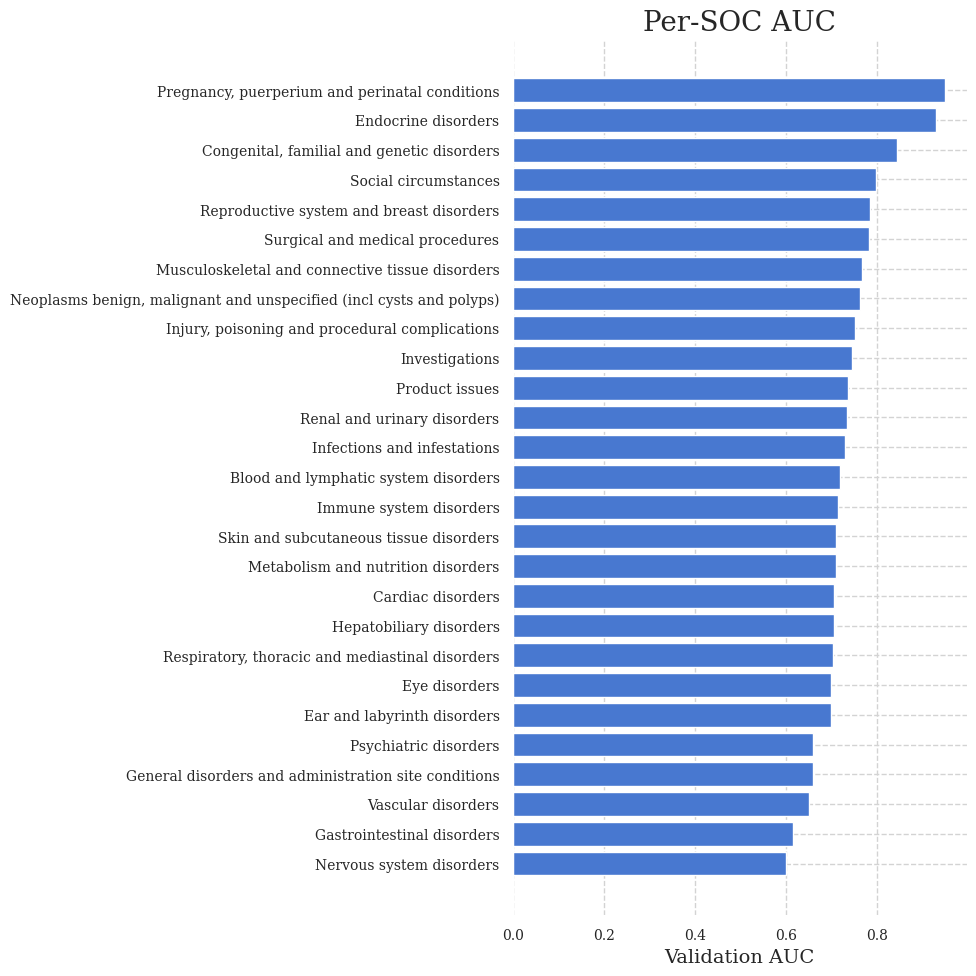

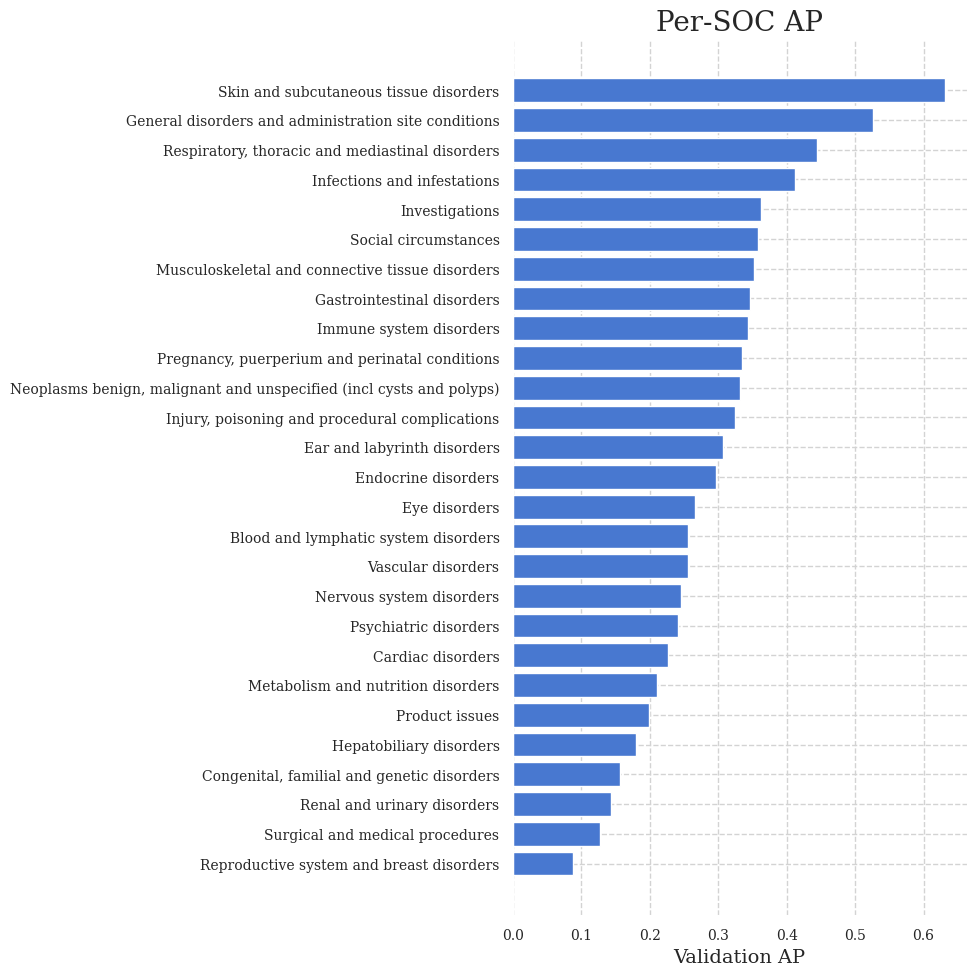

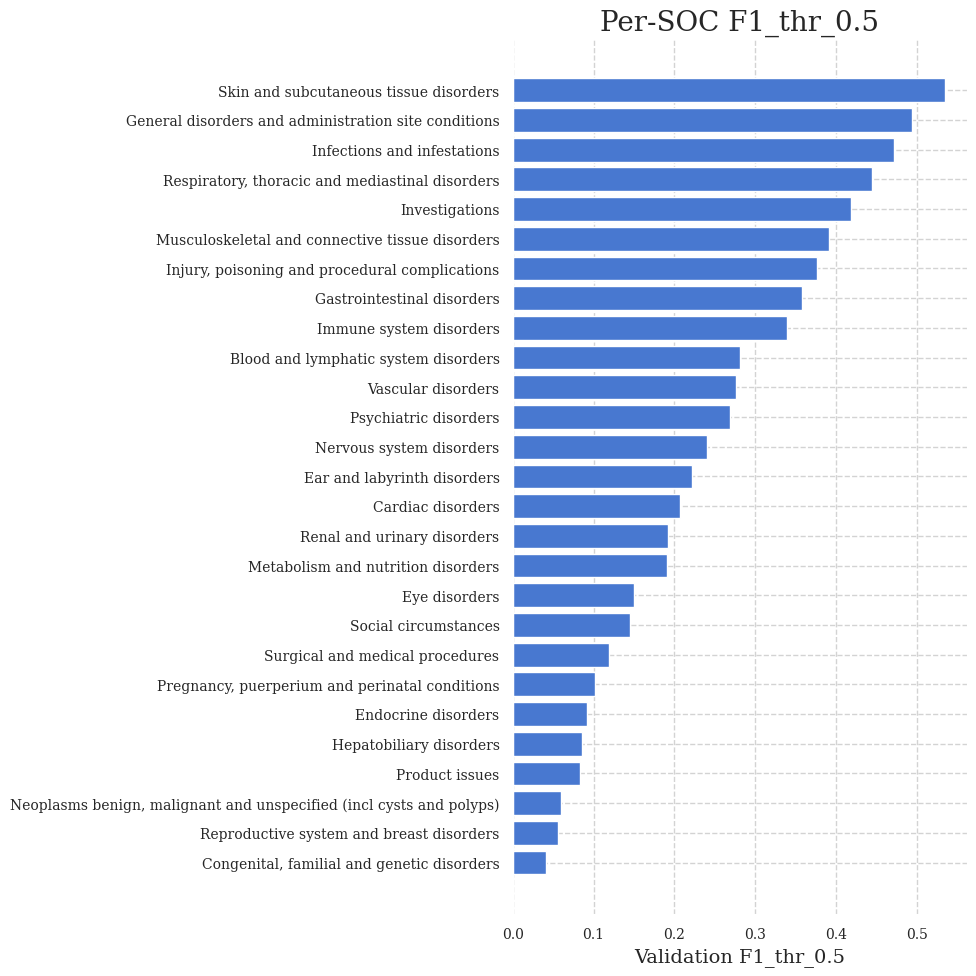

In [12]:
metrics = ["AUC", "AP", "F1_thr_0.5"]

for metric in metrics:

    plt.figure(figsize=(10, 10))
    order = metrics_df.sort_values(metric, ascending=False)["SOC"]

    plt.barh(
        y=range(len(order)),
        width=metrics_df.set_index("SOC").loc[order, metric]
    )
    plt.yticks(range(len(order)), order)
    plt.xlabel(f"Validation {metric}")
    plt.title(f"Per-SOC {metric}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


# Validation

In [ ]:
def predict_all_socs(models, soc_names, X):
    """
    Return DataFrame of P(SOC_k=1 | X) with shape (n_samples, K).
    """
    probs = {}
    for soc in soc_names:
        model_k = models[soc]
        probs[soc] = model_k.predict_proba(X)[:, 1]
    return pd.DataFrame(probs, index=X.index)

Y_valid_probs = predict_all_socs(models, soc_names, X_valid)

In [52]:
# Ground truth and predictions as numpy arrays
treshold = 0.75
Y_true = Y_valid[soc_names].values.astype(int)
Y_pred_05 = (Y_valid_probs[soc_names].values >= treshold).astype(int)

# Micro
micro_f1_05 = f1_score(Y_true, Y_pred_05, average="micro", zero_division=0)
print(f"Micro F1 (thr={treshold}): {micro_f1_05:.3f}")

# Macro
macro_f1_05 = f1_score(Y_true, Y_pred_05, average="macro", zero_division=0)
print(f"Macro F1 (thr={treshold}): {macro_f1_05:.3f}")

# the detection of false positives 
false_positives = np.sum((Y_pred_05 == 1) & (Y_true == 0))
print(f"False Positives (thr={treshold}): {false_positives}")

# FPR
false_positive_rate = false_positives / np.sum(Y_true == 0)
print(f"False Positive Rate (thr={treshold}): {false_positive_rate:.3f}")

# TNR
true_negatives = np.sum((Y_pred_05 == 0) & (Y_true == 0))
true_negative_rate = true_negatives / np.sum(Y_true == 0)
print(f"True Negative Rate (thr={treshold}): {true_negative_rate:.3f}")

# PPV
predicted_positives = np.sum(Y_pred_05 == 1)
if predicted_positives > 0:
    positive_predictive_value = np.sum((Y_pred_05 == 1) & (Y_true == 1)) / predicted_positives
else:
    positive_predictive_value = 0.0
print(f"Positive Predictive Value (thr={treshold}): {positive_predictive_value:.3f}")

# Accuracy
accuracy = accuracy_score(Y_true, Y_pred_05)
print(f"Accuracy (thr={treshold}): {accuracy:.3f}")

Micro F1 (thr=0.75): 0.003
Macro F1 (thr=0.75): 0.002
False Positives (thr=0.75): 0
False Positive Rate (thr=0.75): 0.000
True Negative Rate (thr=0.75): 1.000
Positive Predictive Value (thr=0.75): 1.000
Accuracy (thr=0.75): 0.000


Max FPR: 1.000, at threshold 0.000
Max TNR: 1.000, at threshold 0.727
Max PPV: 1.000, at threshold 0.727
Max Macro F1: 0.256, at threshold 0.535
Max Micro F1: 0.330, at threshold 0.515
Max Accuracy: 0.074, at threshold 0.576


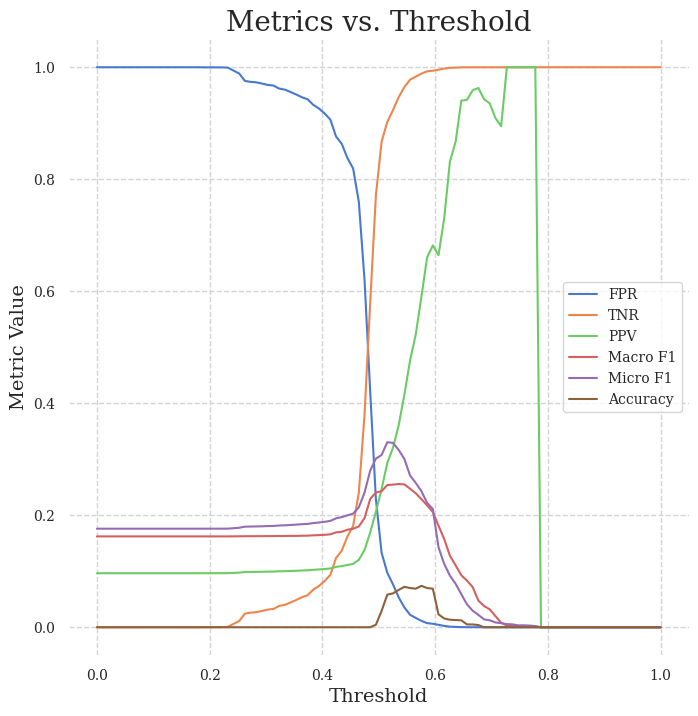

In [63]:
# plot how the FPR changes for each threshold
thresholds = np.linspace(0, 1, 100)

fpr_values = []
tnr_values = []
ppv_values = []
f1_macro_values = []
f1_micro_values = []
acc_values = []

for t in thresholds:
    Y_pred_t = (Y_valid_probs[soc_names].values >= t).astype(int)
    false_positives_t = np.sum((Y_pred_t == 1) & (Y_true == 0))
    fpr_t = false_positives_t / np.sum(Y_true == 0)
    true_negatives_t = np.sum((Y_pred_t == 0) & (Y_true == 0))
    tnr_t = true_negatives_t / np.sum(Y_true == 0)
    ppv_t = np.sum((Y_pred_t == 1) & (Y_true == 1)) / np.sum(Y_pred_t == 1) if np.sum(Y_pred_t == 1) > 0 else 0.0
    ppv_values.append(ppv_t)
    f1_macro_t = f1_score(Y_true, Y_pred_t, average="macro", zero_division=0)
    f1_micro_t = f1_score(Y_true, Y_pred_t, average="micro", zero_division=0)

    acc_t = accuracy_score(Y_true, Y_pred_t)
    acc_values.append(acc_t)
    fpr_values.append(fpr_t)
    f1_macro_values.append(f1_macro_t)
    f1_micro_values.append(f1_micro_t)
    tnr_values.append(tnr_t)

max_fpr = max(fpr_values)
max_tnr = max(tnr_values)
max_ppv = max(ppv_values)
max_f1_macro = max(f1_macro_values)
max_f1_micro = max(f1_micro_values)
max_acc = max(acc_values)

print(f"Max FPR: {max_fpr:.3f}, at threshold {thresholds[np.argmax(fpr_values)]:.3f}")
print(f"Max TNR: {max_tnr:.3f}, at threshold {thresholds[np.argmax(tnr_values)]:.3f}")
print(f"Max PPV: {max_ppv:.3f}, at threshold {thresholds[np.argmax(ppv_values)]:.3f}")
print(f"Max Macro F1: {max_f1_macro:.3f}, at threshold {thresholds[np.argmax(f1_macro_values)]:.3f}")
print(f"Max Micro F1: {max_f1_micro:.3f}, at threshold {thresholds[np.argmax(f1_micro_values)]:.3f}")
print(f"Max Accuracy: {max_acc:.3f}, at threshold {thresholds[np.argmax(acc_values)]:.3f}")

plt.plot(thresholds, fpr_values, label="FPR")
plt.plot(thresholds, tnr_values, label="TNR")
plt.plot(thresholds, ppv_values, label="PPV")
plt.plot(thresholds, f1_macro_values, label="Macro F1")
plt.plot(thresholds, f1_micro_values, label="Micro F1")
plt.plot(thresholds, acc_values, label="Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Metrics vs. Threshold General")
plt.legend()
plt.show()

## Best treshold for each one

In [64]:
def best_threshold_for_f1(y_true, y_prob, n_grid=101):
    """
    Scan thresholds in [0,1] and return (best_tau, best_f1).
    Uses F1-score.
    """
    thresholds = np.linspace(0.0, 1.0, n_grid)
    best_tau = 0.5
    best_f1 = -1.0
    for tau in thresholds:
        y_pred = (y_prob >= tau).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_tau = tau
    return best_tau, best_f1

# Find per-SOC optimal thresholds on the validation data
best_taus = {}
best_f1s = {}

for j, soc in enumerate(soc_names):
    y_true_k = Y_valid[soc].values.astype(int)
    y_prob_k = Y_valid_probs[soc].values
    tau_k, f1_k = best_threshold_for_f1(y_true_k, y_prob_k, n_grid=101)
    best_taus[soc] = tau_k
    best_f1s[soc] = f1_k

best_thresholds_df = (
    pd.DataFrame({"SOC": soc_names, "best_tau": [best_taus[s] for s in soc_names],
                  "best_F1":  [best_f1s[s] for s in soc_names]})
    .set_index("SOC")
)
best_thresholds_df


best_tau   best_F1
SOC                                                                   
Blood and lymphatic system disorders                    0.52  0.294118
Cardiac disorders                                       0.54  0.244444
Congenital, familial and genetic disorders              0.64  0.250000
Ear and labyrinth disorders                             0.62  0.354839
Endocrine disorders                                     0.64  0.307692
Eye disorders                                           0.56  0.333333
Gastrointestinal disorders                              0.49  0.376701
General disorders and administration site condi...      0.49  0.528503
Hepatobiliary disorders                                 0.58  0.222222
Immune system disorders                                 0.55  0.378531
Infections and infestations                             0.50  0.471969
Injury, poisoning and procedural complications          0.51  0.387629
Investigations                                          0.51  0.424084
Metabolism and nutrition disorders                      0.52  0.241611
Musculoskeletal and connective tissue disorders         0.54  0.420804
Neoplasms benign, malignant and unspecified (in...      0.64  0.413793
Nervous system disorders                                0.49  0.280609
Pregnancy, puerperium and perinatal conditions          0.58  0.428571
Product issues                                          0.62  0.285714
Psychiatric disorders                                   0.51  0.292208
Renal and urinary disorders                             0.55  0.236842
Reproductive system and breast disorders                0.57  0.105263
Respiratory, thoracic and mediastinal disorders         0.49  0.452261
Skin and subcutaneous tissue disorders                  0.48  0.611215
Social circumstances                                    0.56  0.428571
Surgical and medical procedures                         0.59  0.204082
Vascular disorders                                      0.52  0.280000

In [65]:
# Apply SOC-specific thresholds
Y_pred_custom = np.zeros_like(Y_true, dtype=int)

for j, soc in enumerate(soc_names):
    tau_k = best_taus[soc]
    Y_pred_custom[:, j] = (Y_valid_probs[soc].values >= tau_k).astype(int)

micro_f1_custom = f1_score(Y_true, Y_pred_custom, average="micro", zero_division=0)
macro_f1_custom = f1_score(Y_true, Y_pred_custom, average="macro", zero_division=0)

print(f"Micro F1 (SOC-specific tau): {micro_f1_custom:.3f}")
print(f"Macro F1 (SOC-specific tau): {macro_f1_custom:.3f}")

Micro F1 (SOC-specific tau): 0.424
Macro F1 (SOC-specific tau): 0.343


# Feature importance using PredictionValuesChange

In [58]:
# feature_importances: DataFrame (SOC × feature)
feature_importances = pd.DataFrame(
    0.0,
    index=soc_names,
    columns=feature_names
)

for soc in soc_names:
    model_k = models[soc]
    # Default feature importance; you can also use type="PredictionValuesChange"
    imp_k = model_k.get_feature_importance(type="FeatureImportance")
    feature_importances.loc[soc, :] = imp_k

# drop if all the columnss are close to zero
feature_importances = feature_importances.loc[:, (feature_importances.abs() > 1).any(axis=0)]
feature_importances


AGE_Y  WEIGHT_KG  \
Blood and lymphatic system disorders                 0.000000   0.000000   
Cardiac disorders                                    0.000000   0.000000   
Congenital, familial and genetic disorders          51.190605   0.000000   
Ear and labyrinth disorders                         11.188684   0.000000   
Endocrine disorders                                 20.374933   0.000000   
Eye disorders                                       14.575514   7.390783   
Gastrointestinal disorders                           0.000000   0.000000   
General disorders and administration site condi...   8.021897   5.272861   
Hepatobiliary disorders                              6.778231   4.460415   
Immune system disorders                              6.708706   0.000000   
Infections and infestations                         14.346198   0.000000   
Injury, poisoning and procedural complications       0.000000   0.000000   
Investigations                                       0.000000   9.218411   
Metabolism and nutrition disorders                   2.272516   0.000000   
Musculoskeletal and connective tissue disorders      1.638148   5.480245   
Neoplasms benign, malignant and unspecified (in...  17.178638   5.256239   
Nervous system disorders                             2.022654   2.628679   
Pregnancy, puerperium and perinatal conditions      36.136092   8.499998   
Product issues                                       8.298264   7.102906   
Psychiatric disorders                                0.000000   0.000000   
Renal and urinary disorders                          5.647135   6.371883   
Reproductive system and breast disorders            21.022077   0.000000   
Respiratory, thoracic and mediastinal disorders      0.000000   0.000000   
Skin and subcutaneous tissue disorders               0.000000   0.000000   
Social circumstances                                 0.000000   0.000000   
Surgical and medical procedures                      4.398453   1.560009   
Vascular disorders                                   0.000000   7.619086   

                                                    HEIGHT_CM  GENDER_CODE  \
Blood and lymphatic system disorders                 0.000000     0.000000   
Cardiac disorders                                    0.000000     0.000000   
Congenital, familial and genetic disorders           0.000000     0.000000   
Ear and labyrinth disorders                          3.330825     0.000000   
Endocrine disorders                                  0.000000     0.000000   
Eye disorders                                        3.519209     0.000000   
Gastrointestinal disorders                           2.173889     4.500409   
General disorders and administration site condi...   0.000000     0.000000   
Hepatobiliary disorders                              0.000000     0.000000   
Immune system disorders                              0.000000     0.000000   
Infections and infestations                          0.000000     0.000000   
Injury, poisoning and procedural complications       0.000000     0.000000   
Investigations                                       0.000000     0.000000   
Metabolism and nutrition disorders                   0.000000     0.000000   
Musculoskeletal and connective tissue disorders      0.000000     0.000000   
Neoplasms benign, malignant and unspecified (in...   0.000000     0.000000   
Nervous system disorders                             1.155378     0.000000   
Pregnancy, puerperium and perinatal conditions       8.074786    18.888959   
Product issues                                       0.000000     0.000000   
Psychiatric disorders                                0.000000     0.000000   
Renal and urinary disorders                          0.000000     3.103513   
Reproductive system and breast disorders            10.121698     2.421774   
Respiratory, thoracic and mediastinal disorders      0.000000     0.000000   
Skin and subcutaneous tissue disorders               0.

In [23]:
feature_importances_pvc = pd.DataFrame(
    0.0,
    index=soc_names,
    columns=feature_names
)

for soc in soc_names:
    model_k = models[soc]
    imp_k = model_k.get_feature_importance(type="PredictionValuesChange")
    feature_importances_pvc.loc[soc, :] = imp_k

feature_importances_pvc

AGE_Y  WEIGHT_KG  \
Blood and lymphatic system disorders                 0.000000   0.000000   
Cardiac disorders                                    0.000000   0.000000   
Congenital, familial and genetic disorders          51.190605   0.000000   
Ear and labyrinth disorders                         11.188684   0.000000   
Endocrine disorders                                 20.374933   0.000000   
Eye disorders                                       14.575514   7.390783   
Gastrointestinal disorders                           0.000000   0.000000   
General disorders and administration site condi...   8.021897   5.272861   
Hepatobiliary disorders                              6.778231   4.460415   
Immune system disorders                              6.708706   0.000000   
Infections and infestations                         14.346198   0.000000   
Injury, poisoning and procedural complications       0.000000   0.000000   
Investigations                                       0.000000   9.218411   
Metabolism and nutrition disorders                   2.272516   0.000000   
Musculoskeletal and connective tissue disorders      1.638148   5.480245   
Neoplasms benign, malignant and unspecified (in...  17.178638   5.256239   
Nervous system disorders                             2.022654   2.628679   
Pregnancy, puerperium and perinatal conditions      36.136092   8.499998   
Product issues                                       8.298264   7.102906   
Psychiatric disorders                                0.000000   0.000000   
Renal and urinary disorders                          5.647135   6.371883   
Reproductive system and breast disorders            21.022077   0.000000   
Respiratory, thoracic and mediastinal disorders      0.000000   0.000000   
Skin and subcutaneous tissue disorders               0.000000   0.000000   
Social circumstances                                 0.000000   0.000000   
Surgical and medical procedures                      4.398453   1.560009   
Vascular disorders                                   0.000000   7.619086   

                                                    HEIGHT_CM  GENDER_CODE  \
Blood and lymphatic system disorders                 0.000000     0.000000   
Cardiac disorders                                    0.000000     0.000000   
Congenital, familial and genetic disorders           0.000000     0.000000   
Ear and labyrinth disorders                          3.330825     0.000000   
Endocrine disorders                                  0.000000     0.000000   
Eye disorders                                        3.519209     0.000000   
Gastrointestinal disorders                           2.173889     4.500409   
General disorders and administration site condi...   0.000000     0.000000   
Hepatobiliary disorders                              0.000000     0.000000   
Immune system disorders                              0.000000     0.000000   
Infections and infestations                          0.000000     0.000000   
Injury, poisoning and procedural complications       0.000000     0.000000   
Investigations                                       0.000000     0.000000   
Metabolism and nutrition disorders                   0.000000     0.000000   
Musculoskeletal and connective tissue disorders      0.000000     0.000000   
Neoplasms benign, malignant and unspecified (in...   0.000000     0.000000   
Nervous system disorders                             1.155378     0.000000   
Pregnancy, puerperium and perinatal conditions       8.074786    18.888959   
Product issues                                       0.000000     0.000000   
Psychiatric disorders                                0.000000     0.000000   
Renal and urinary disorders                          0.000000     3.103513   
Reproductive system and breast disorders            10.121698     2.421774   
Respiratory, thoracic and mediastinal disorders      0.000000     0.000000   
Skin and subcutaneous tissue disorders               0.

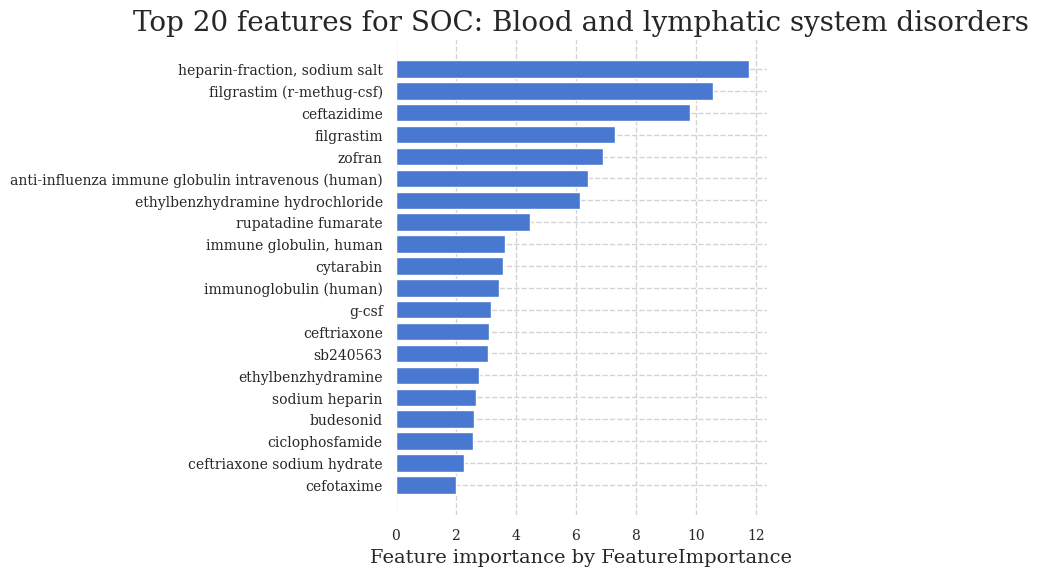

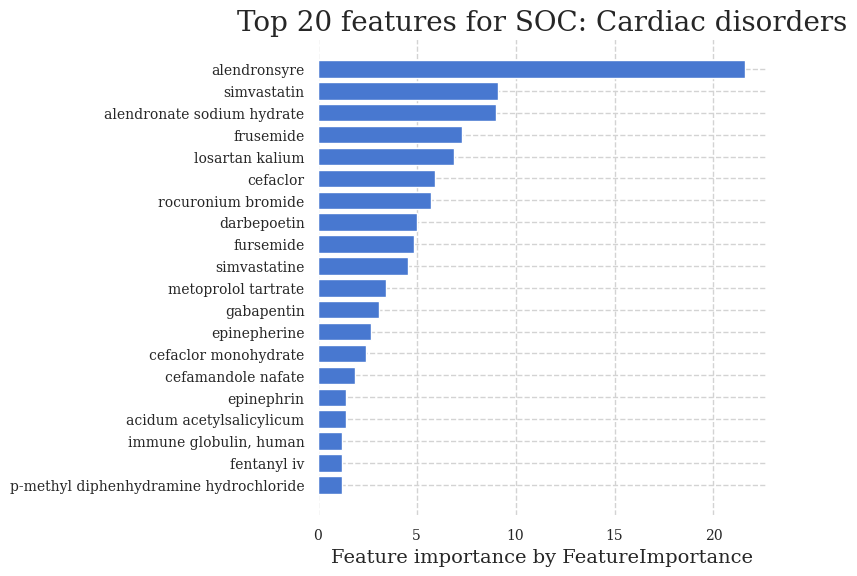

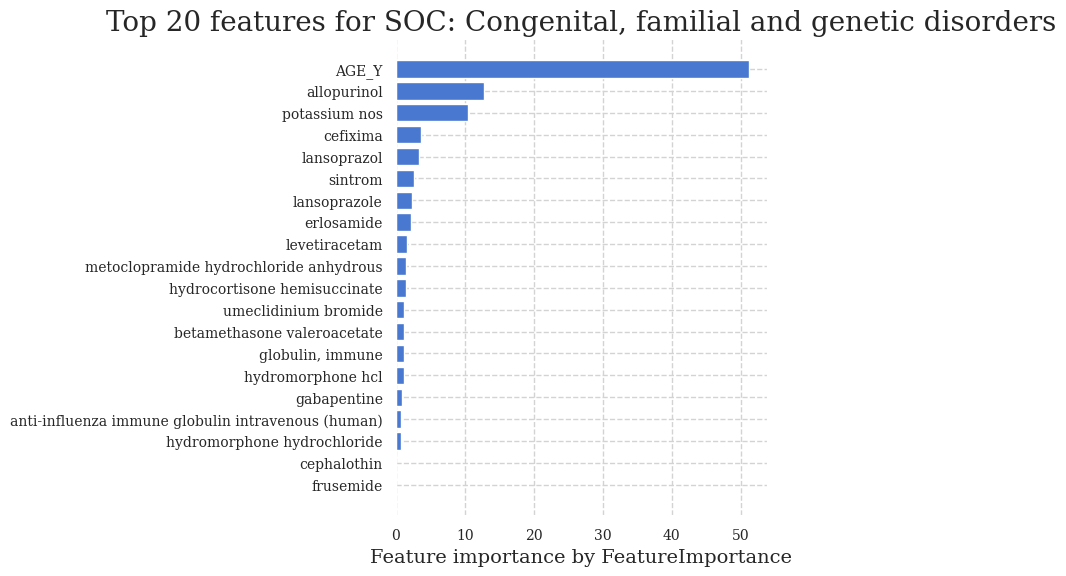

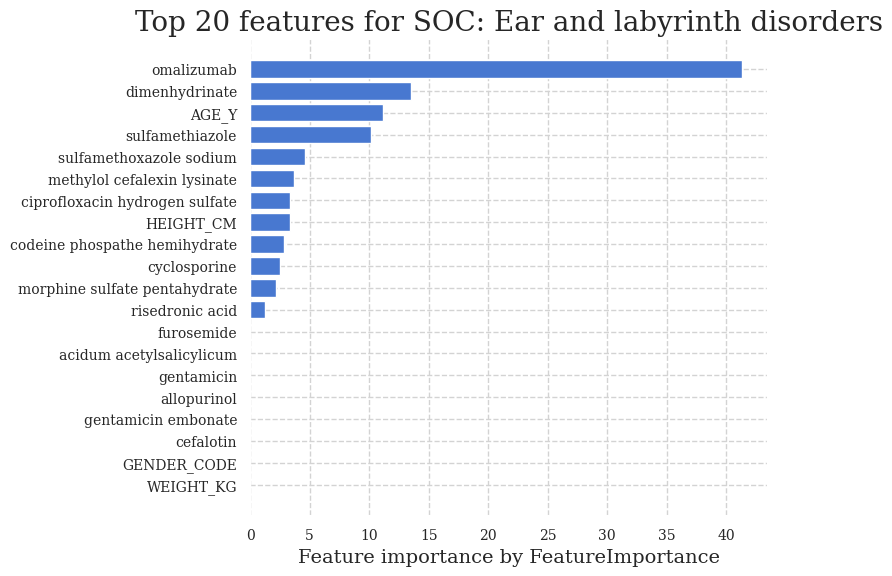

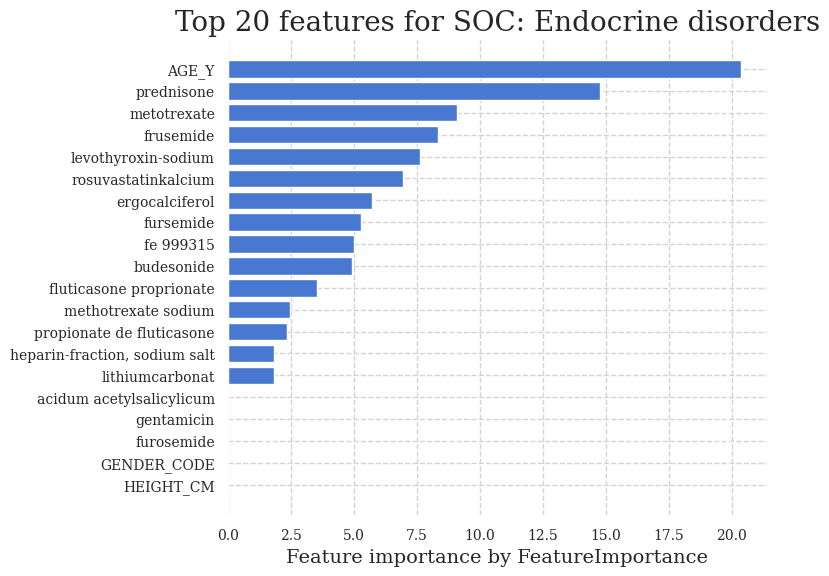

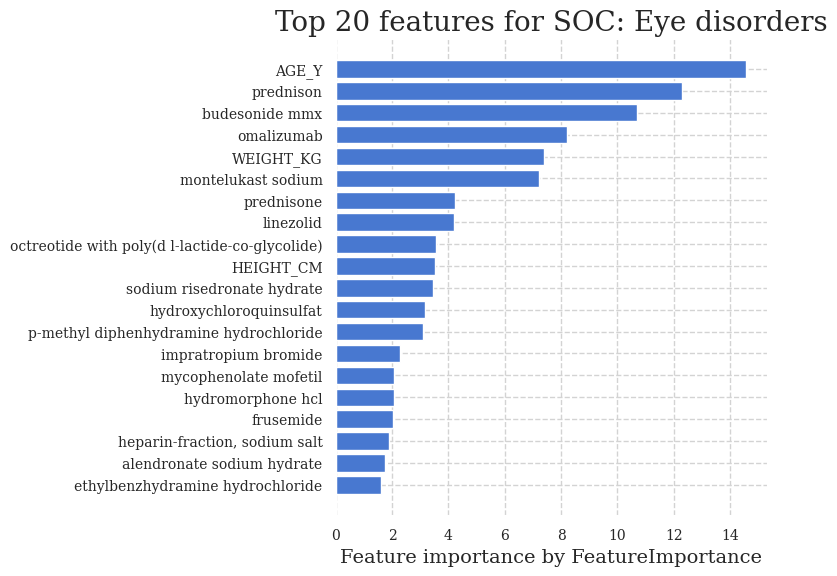

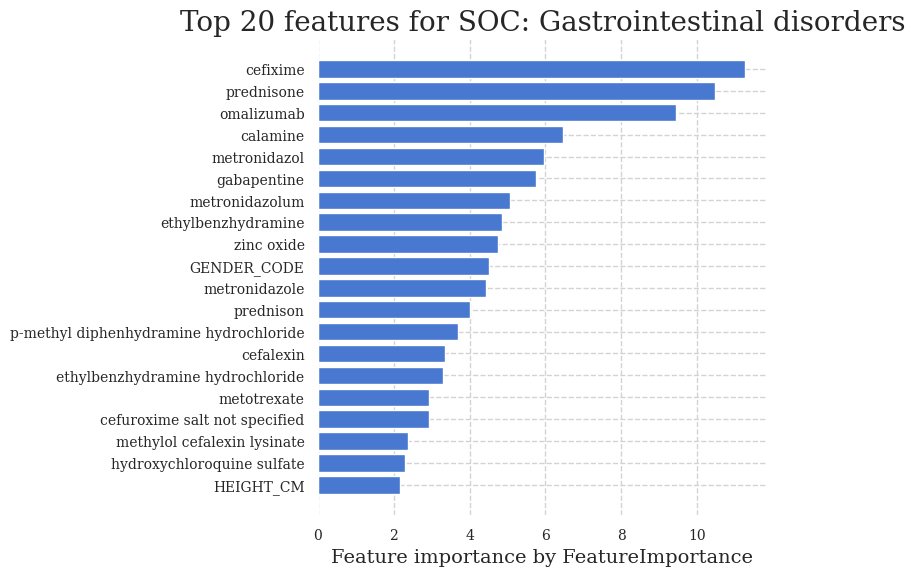

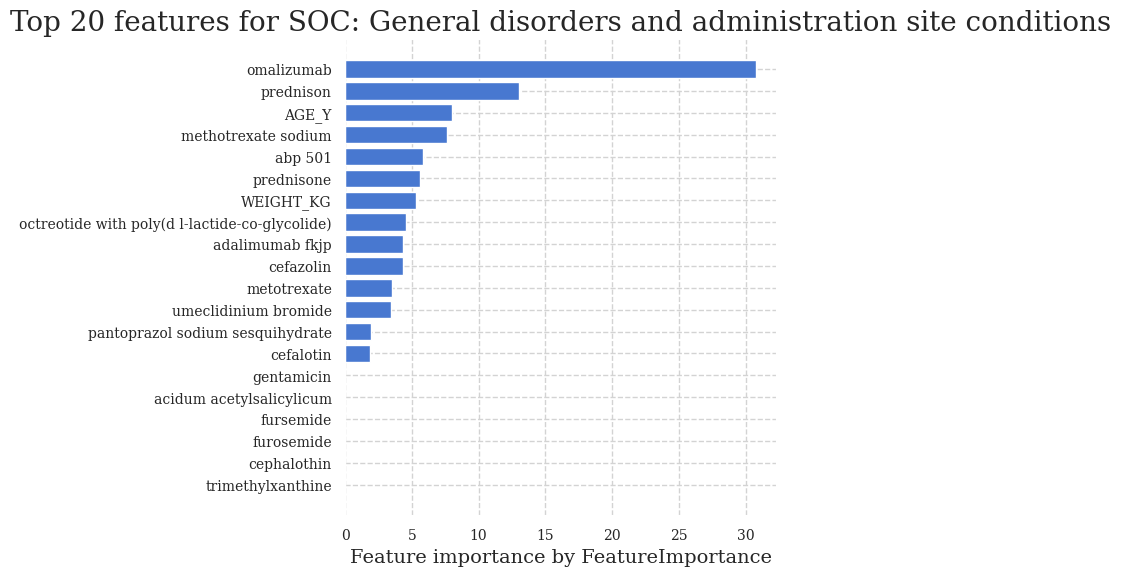

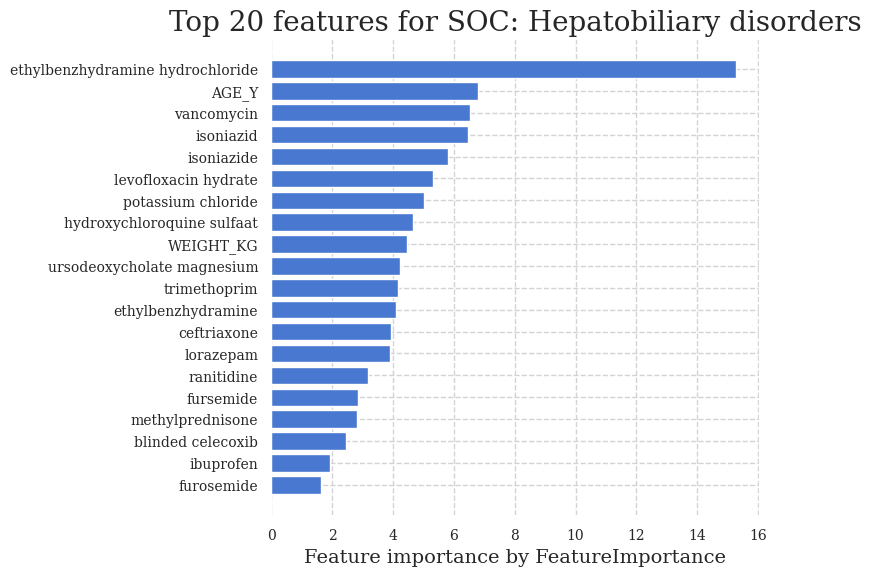

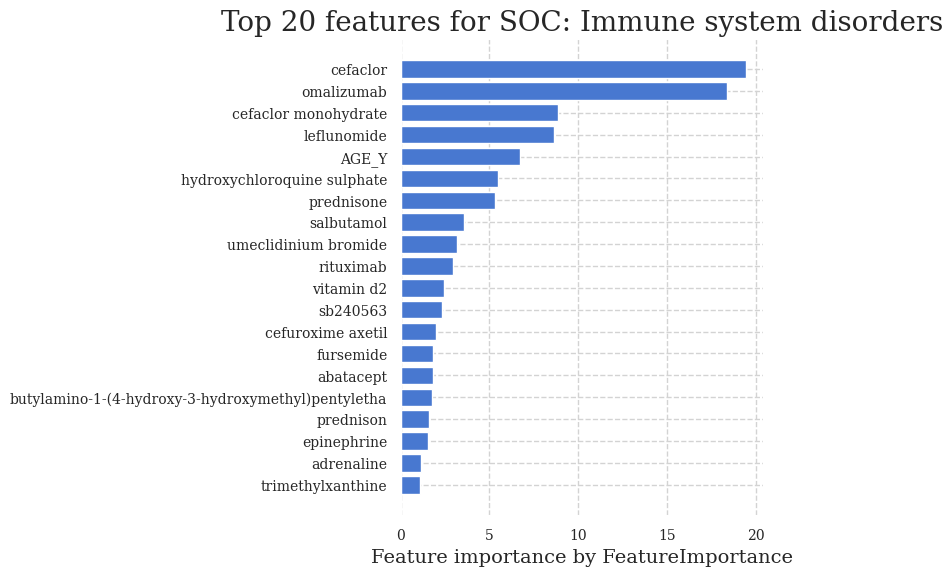

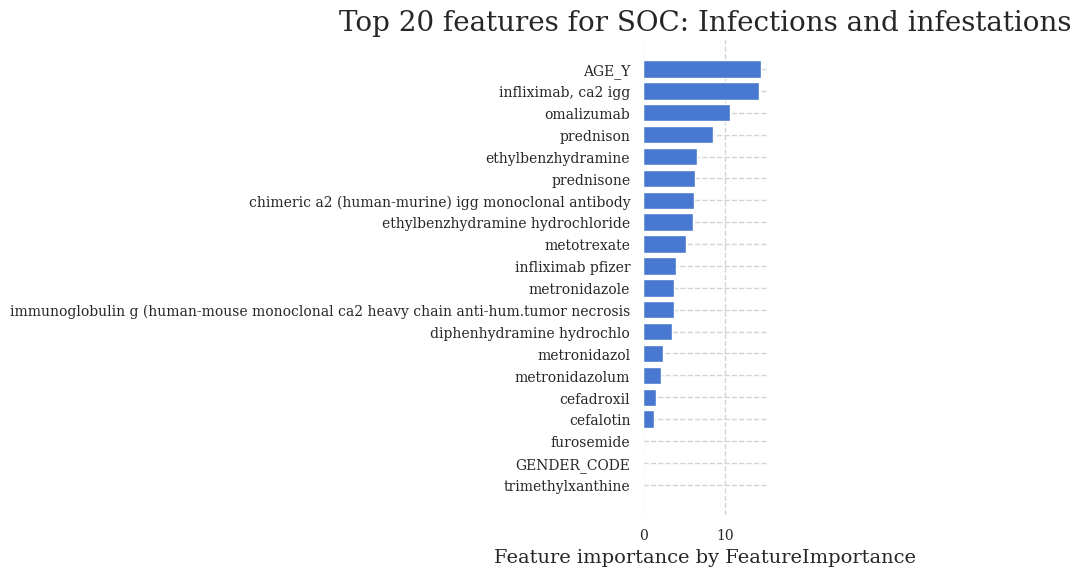

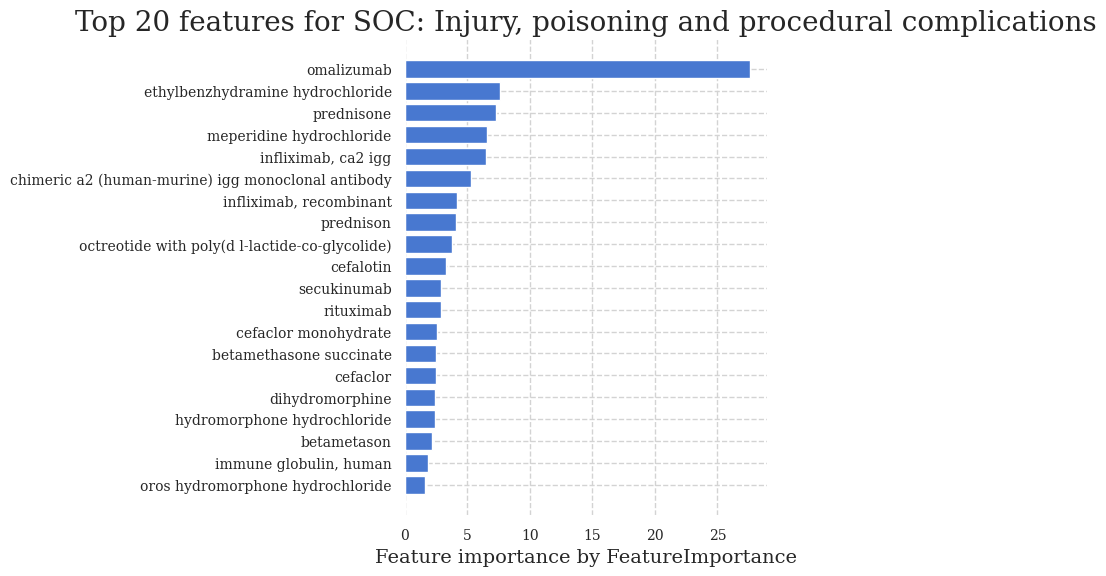

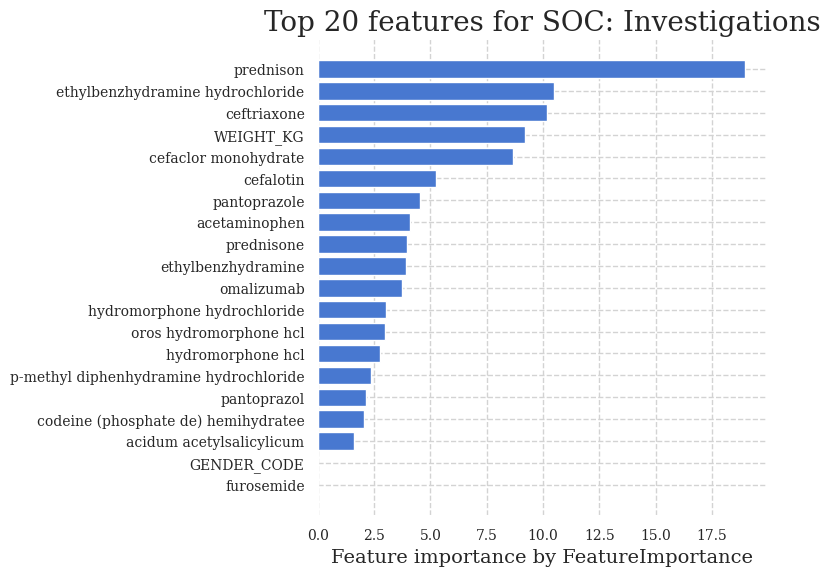

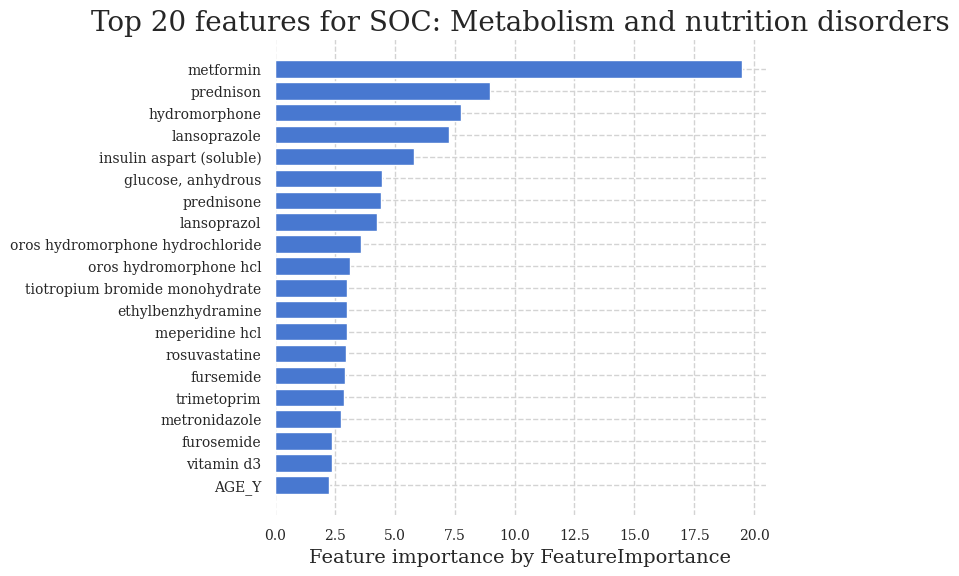

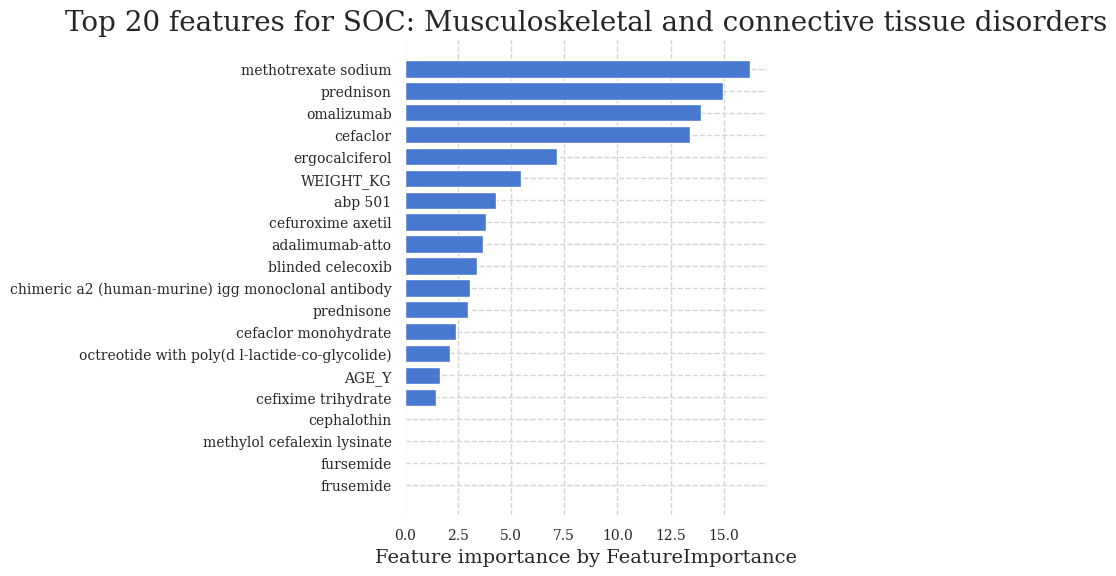

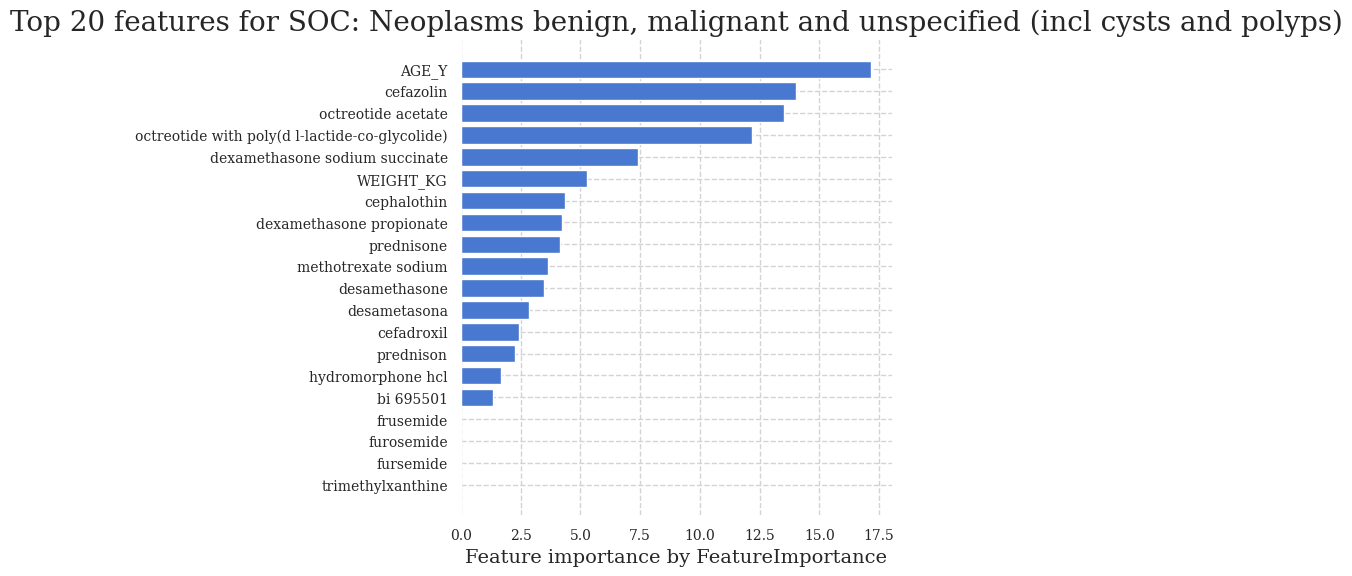

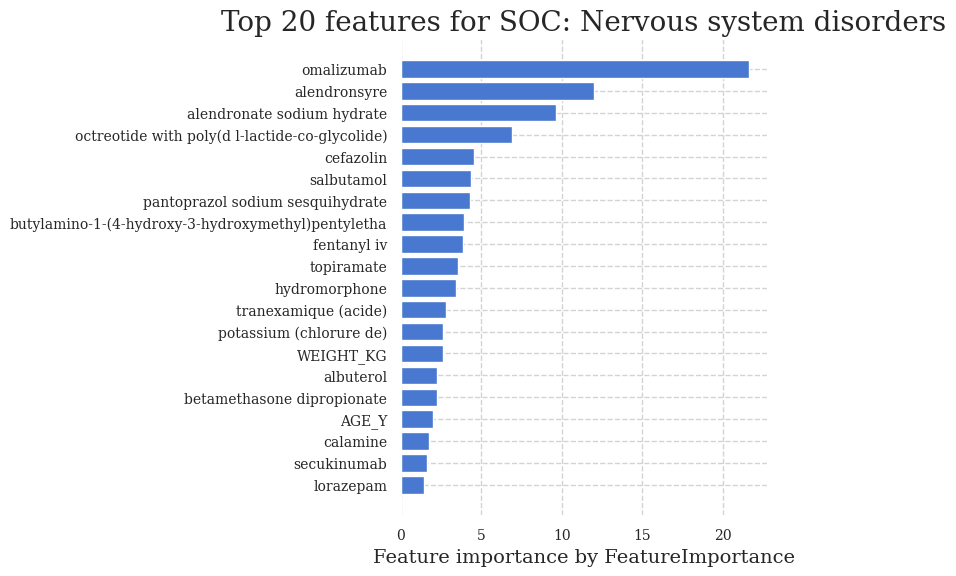

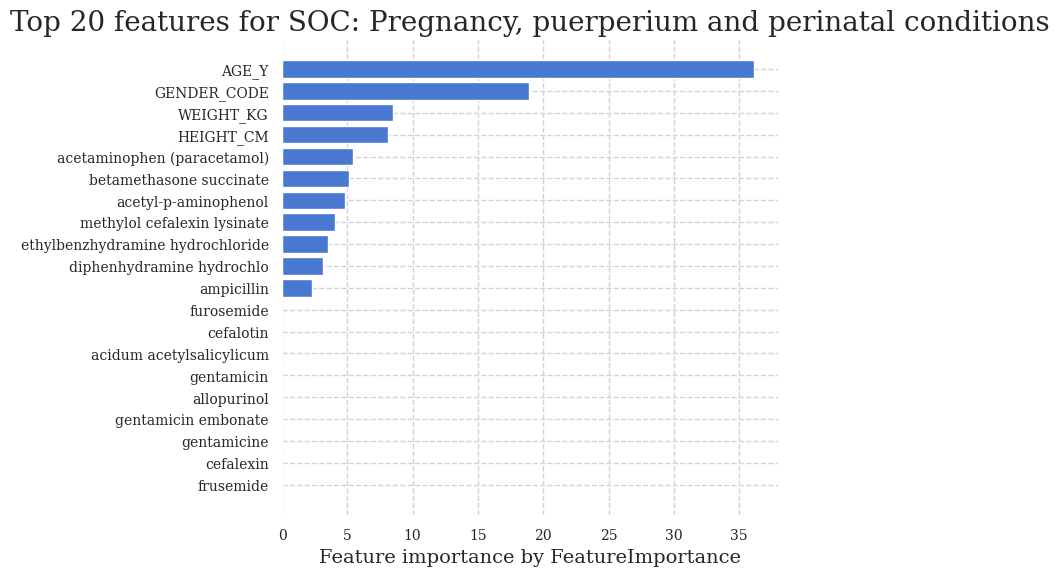

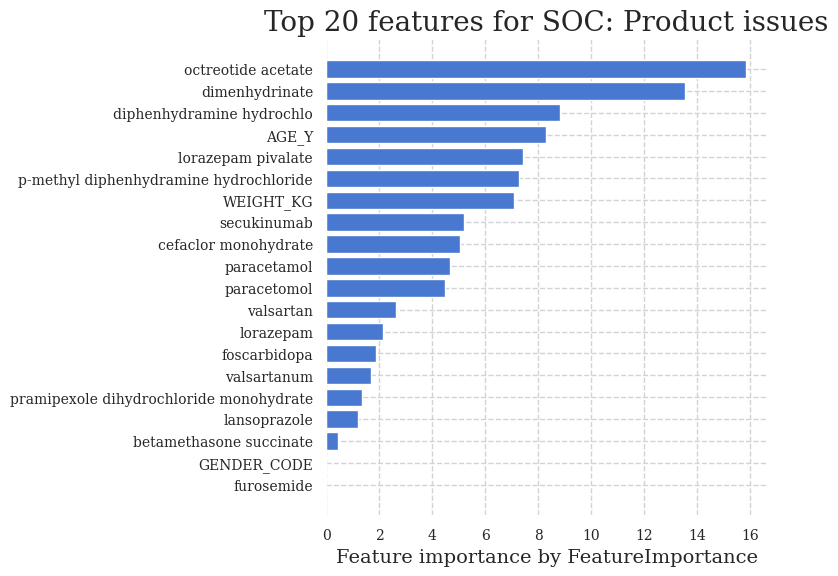

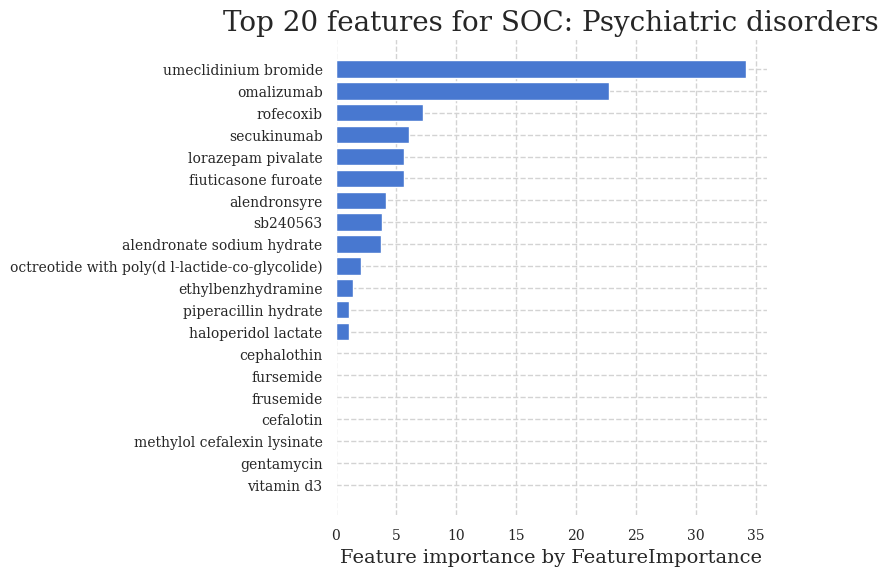

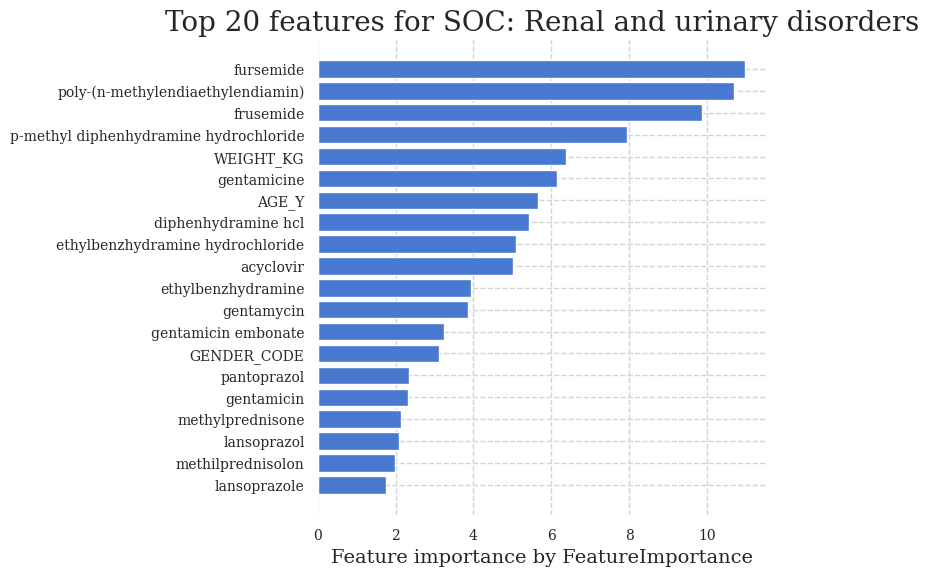

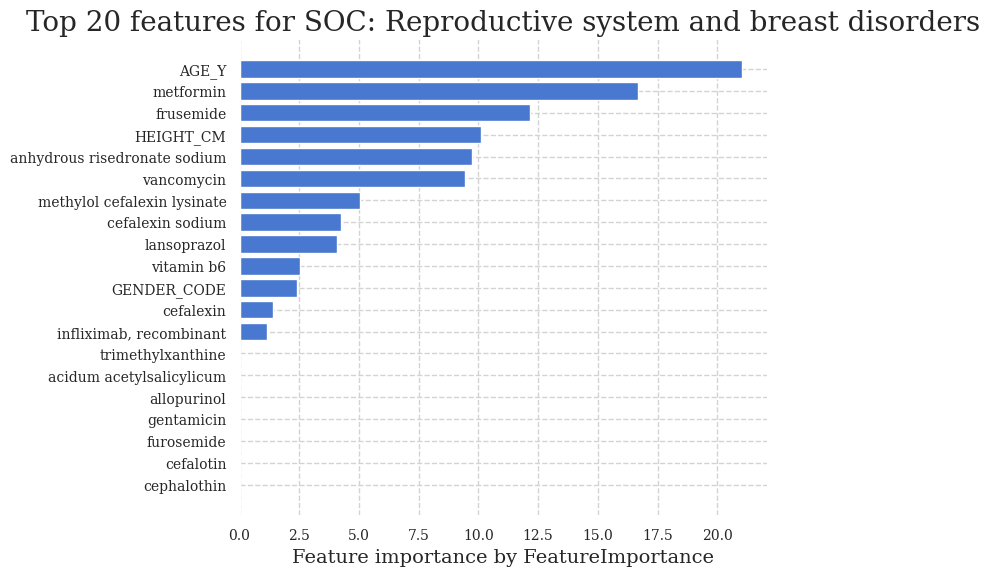

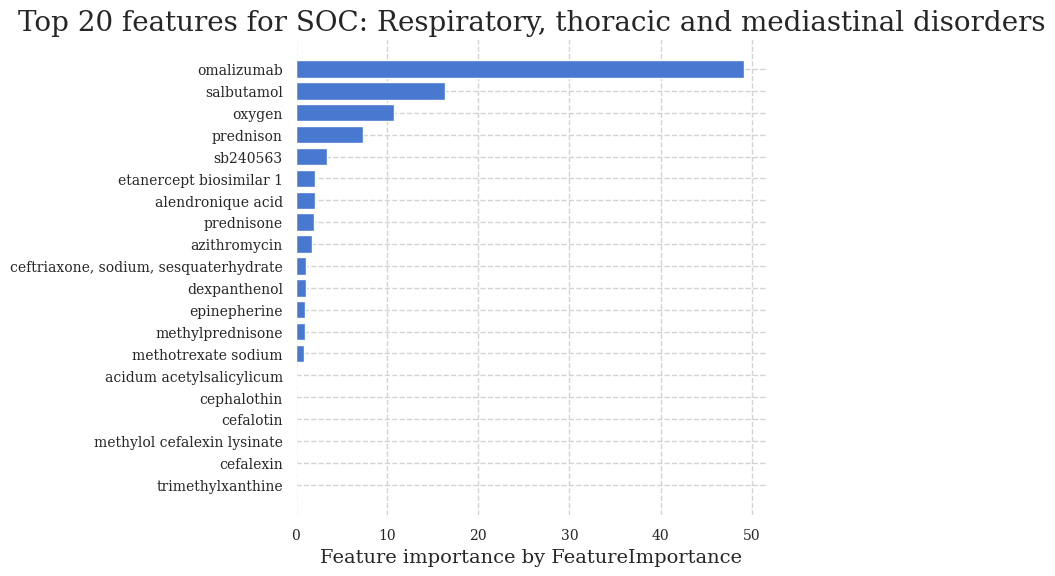

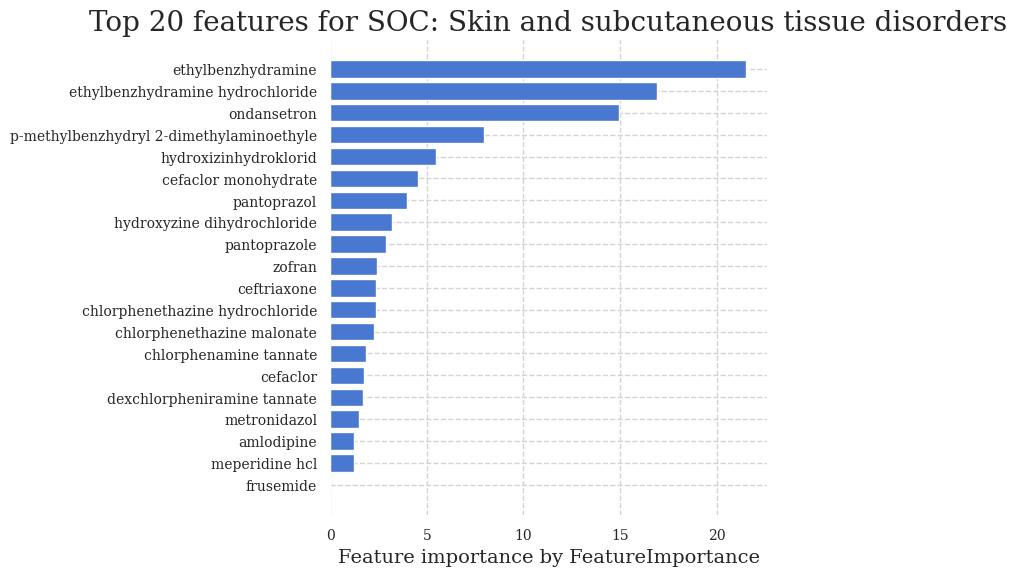

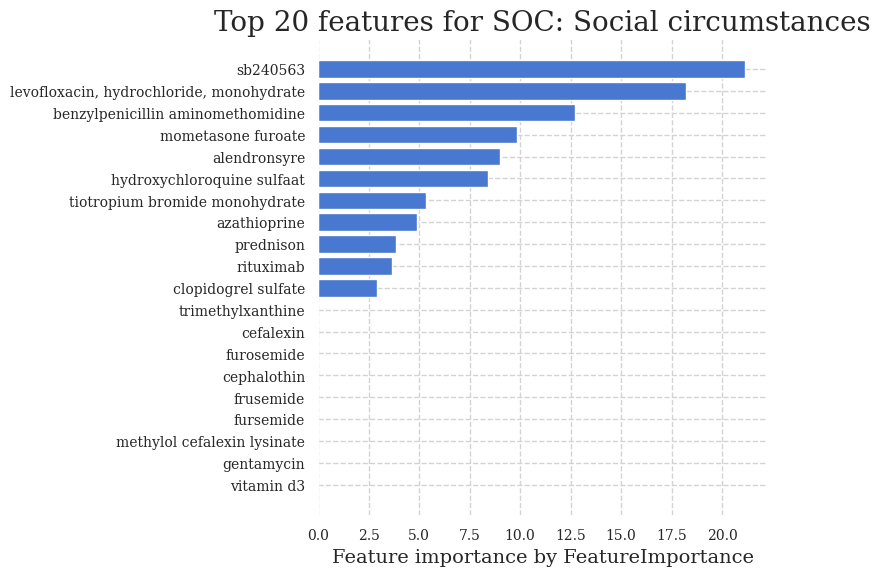

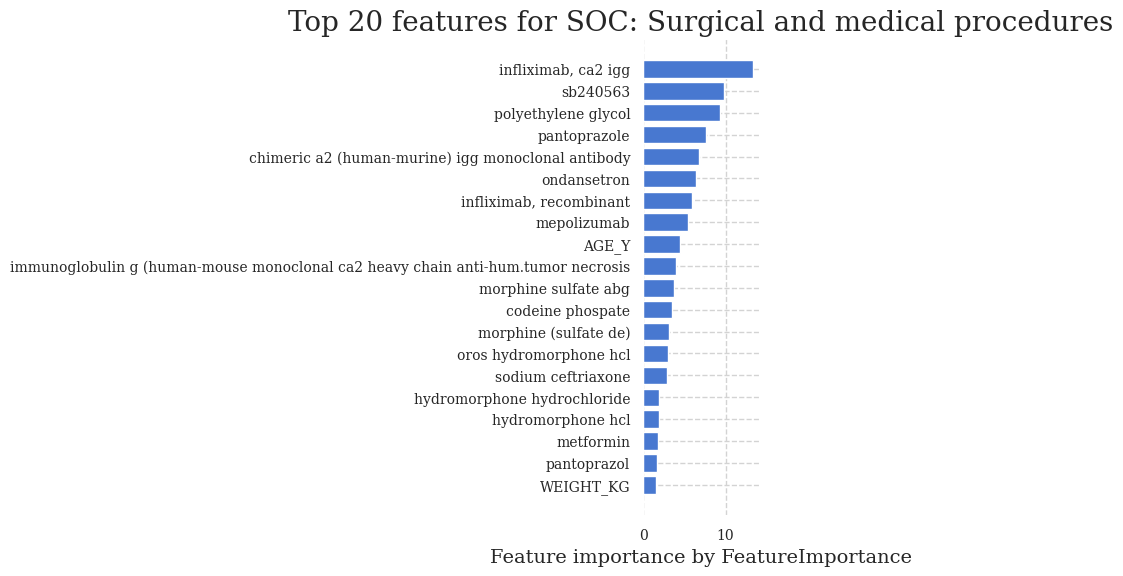

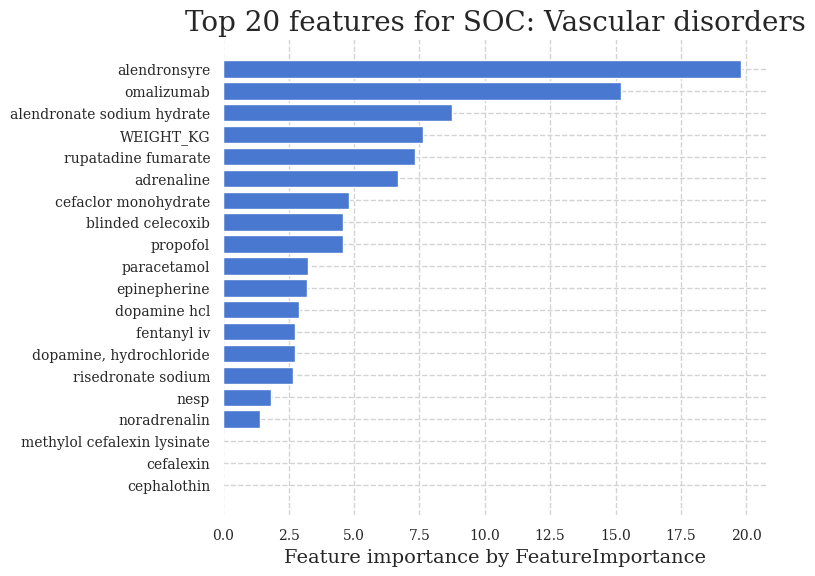

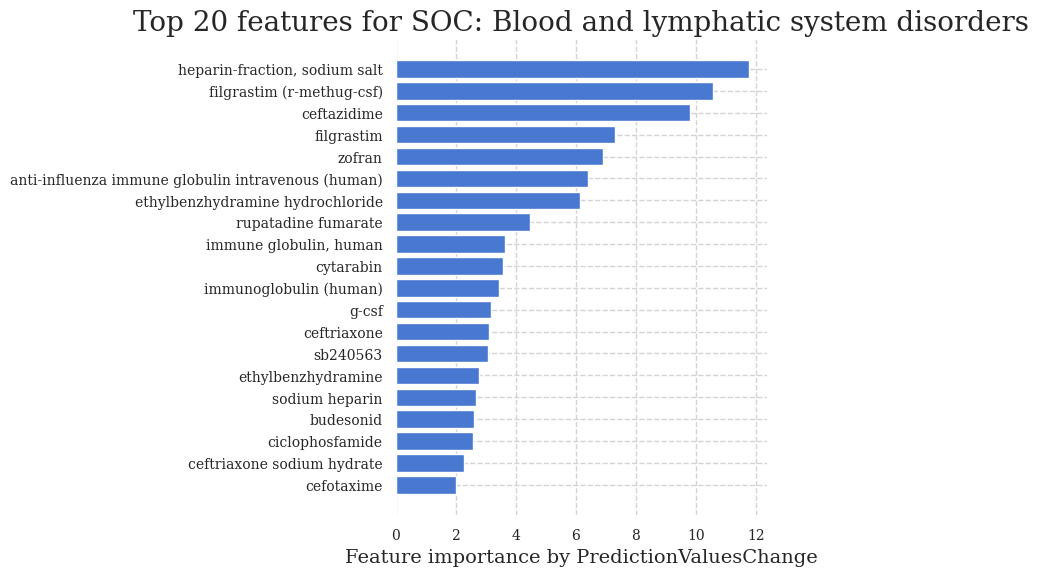

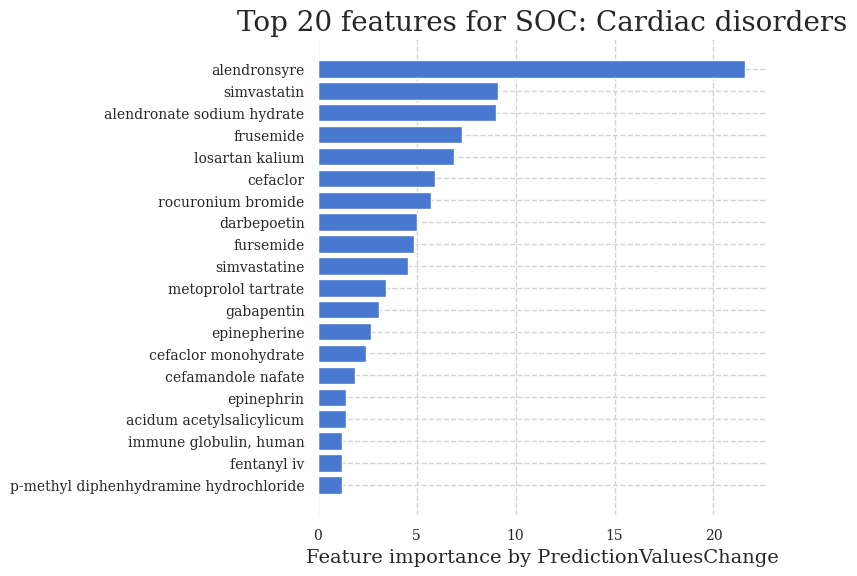

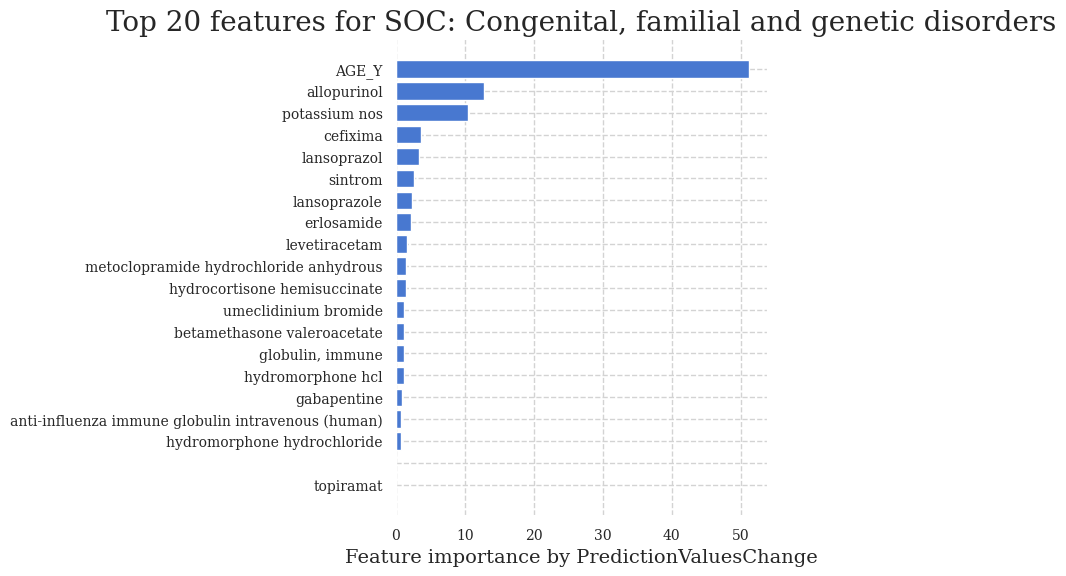

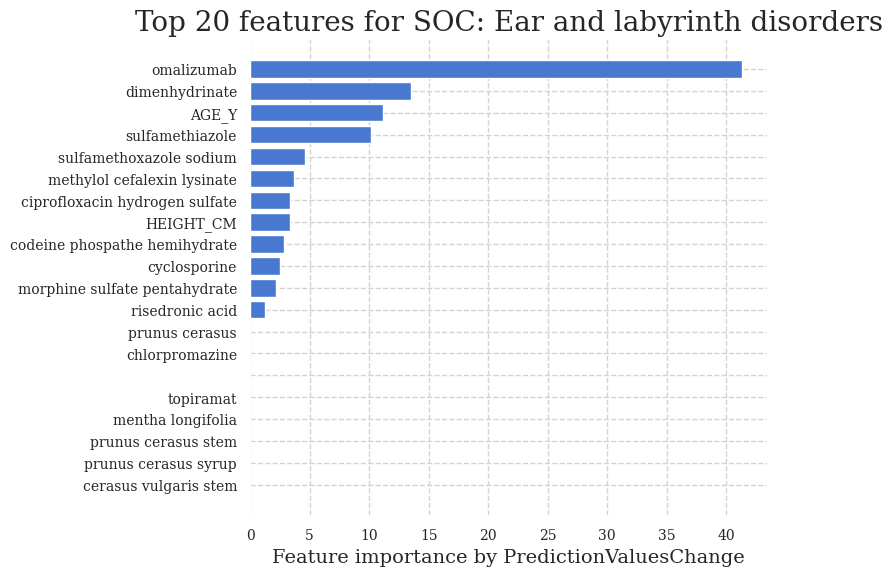

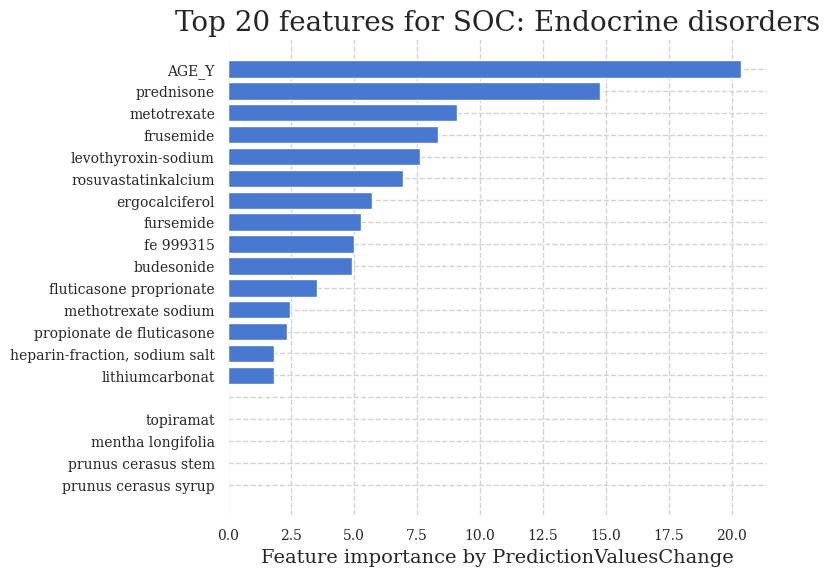

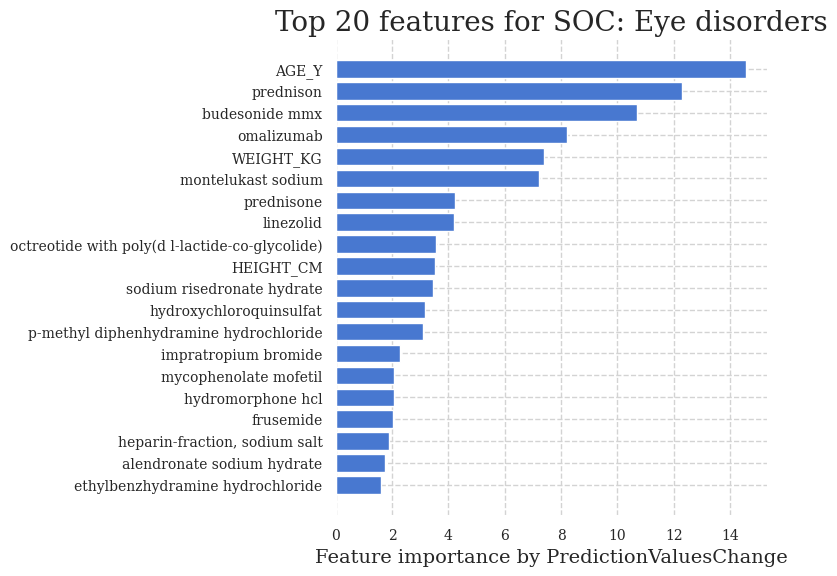

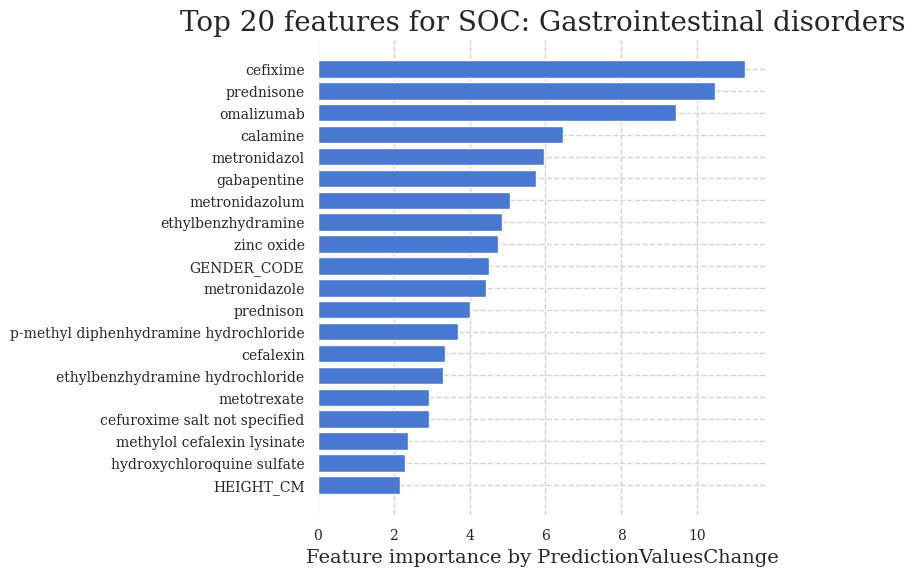

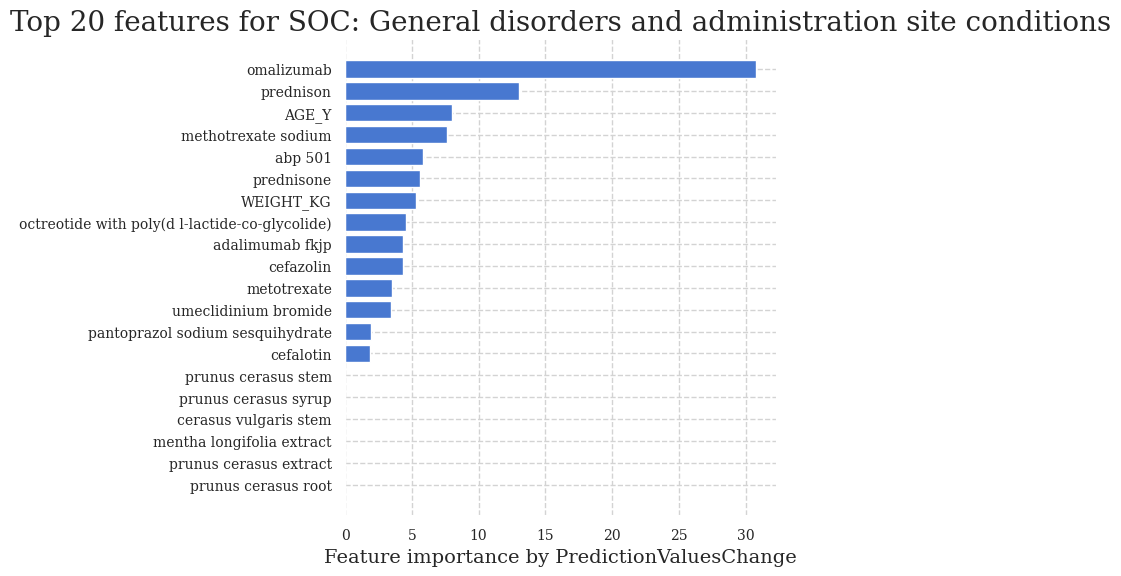

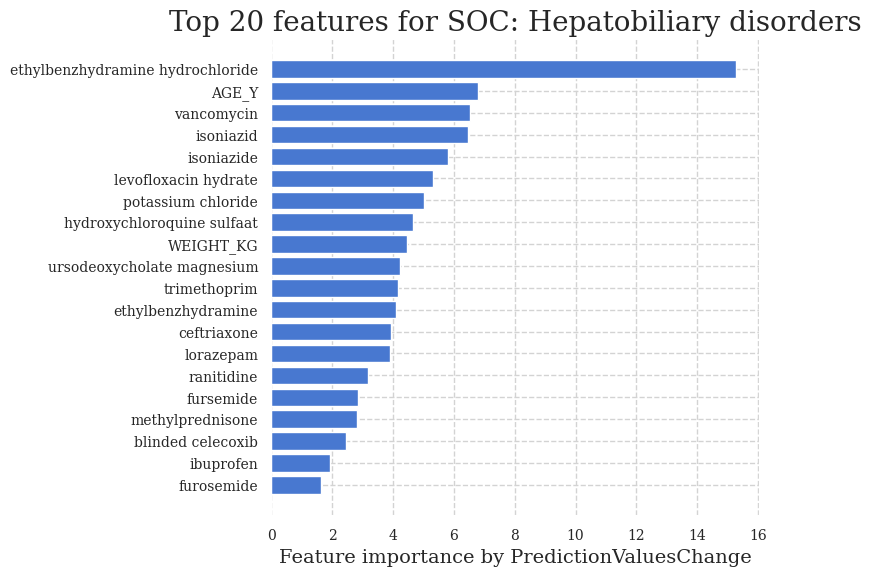

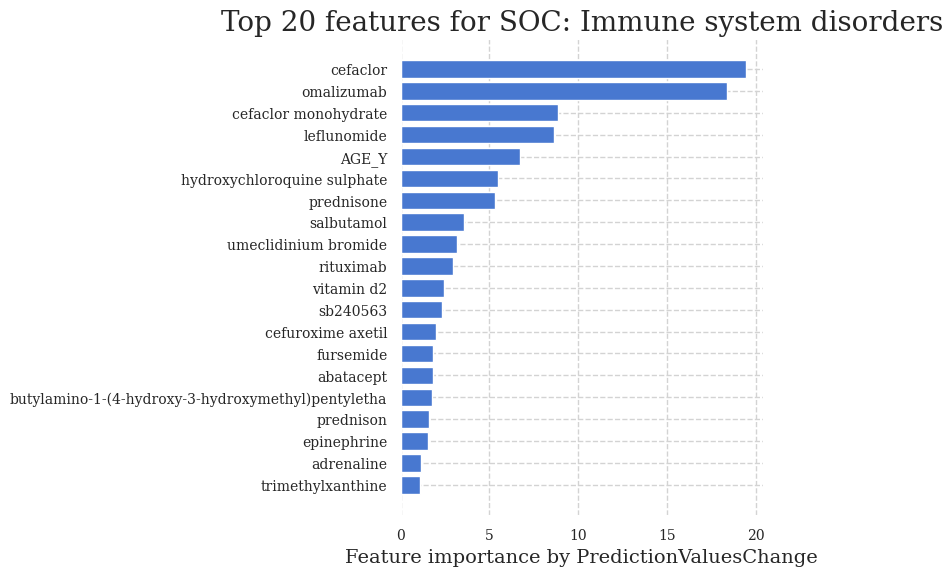

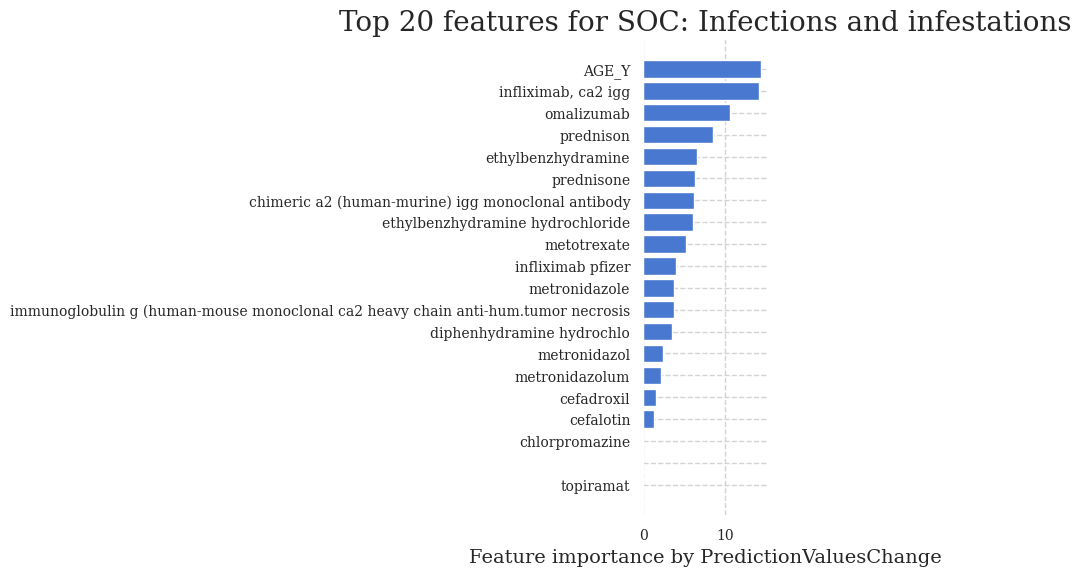

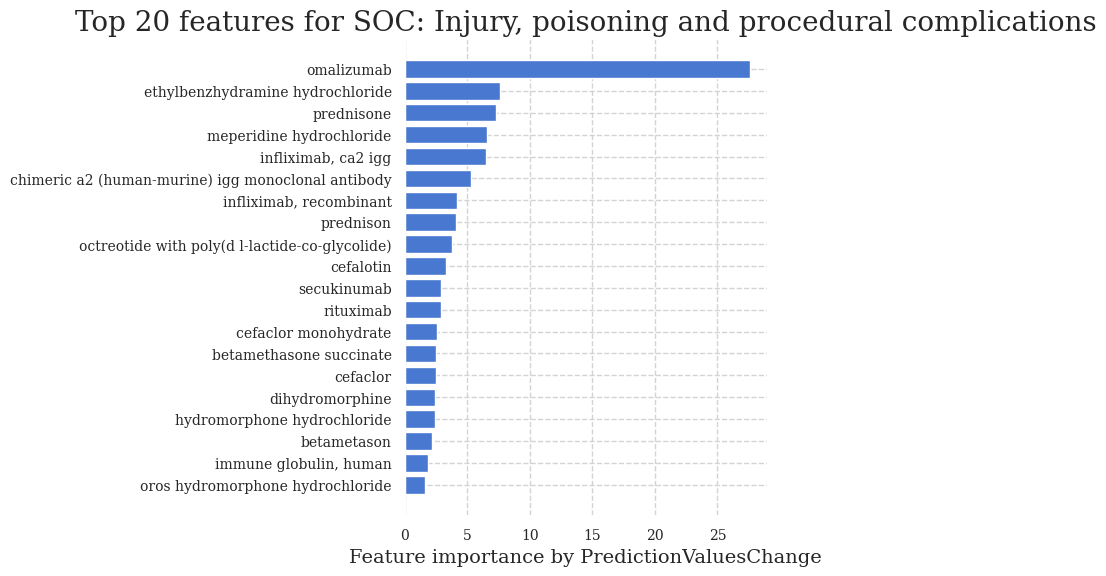

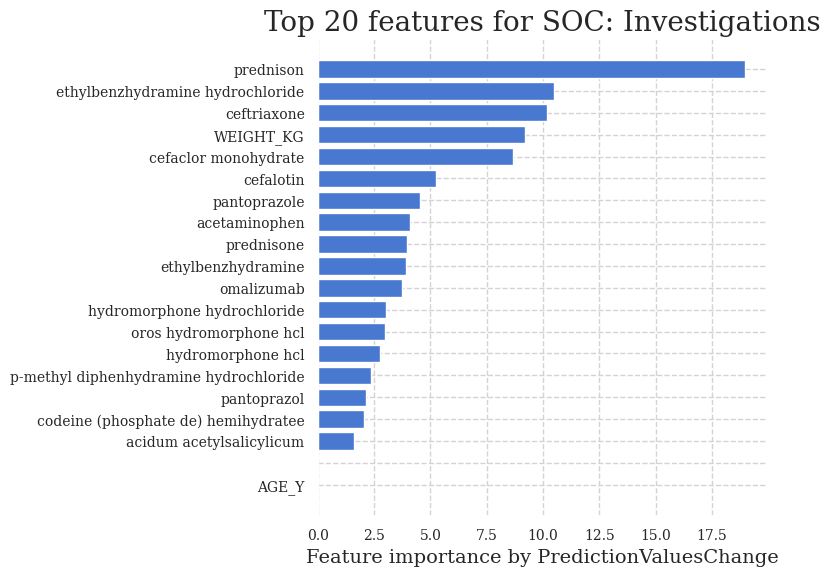

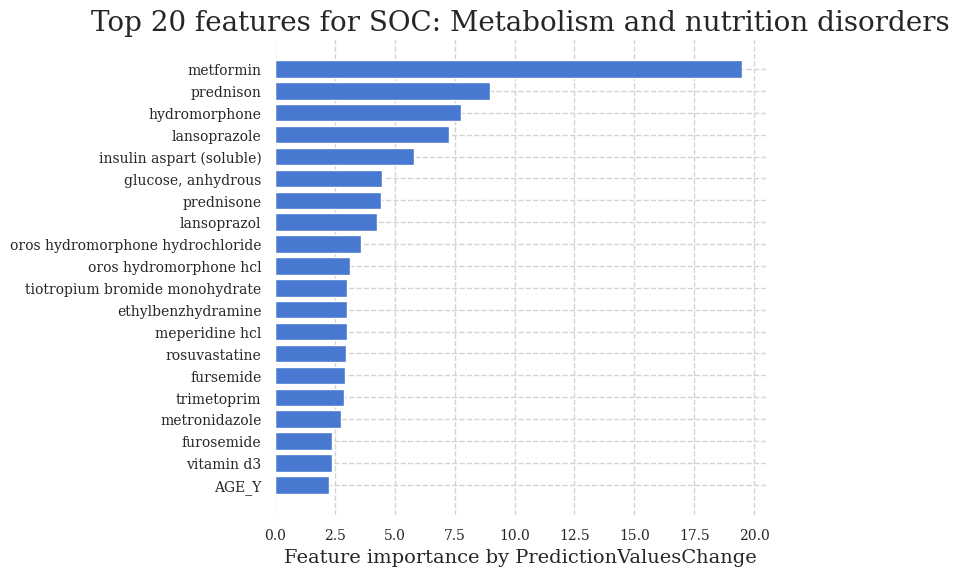

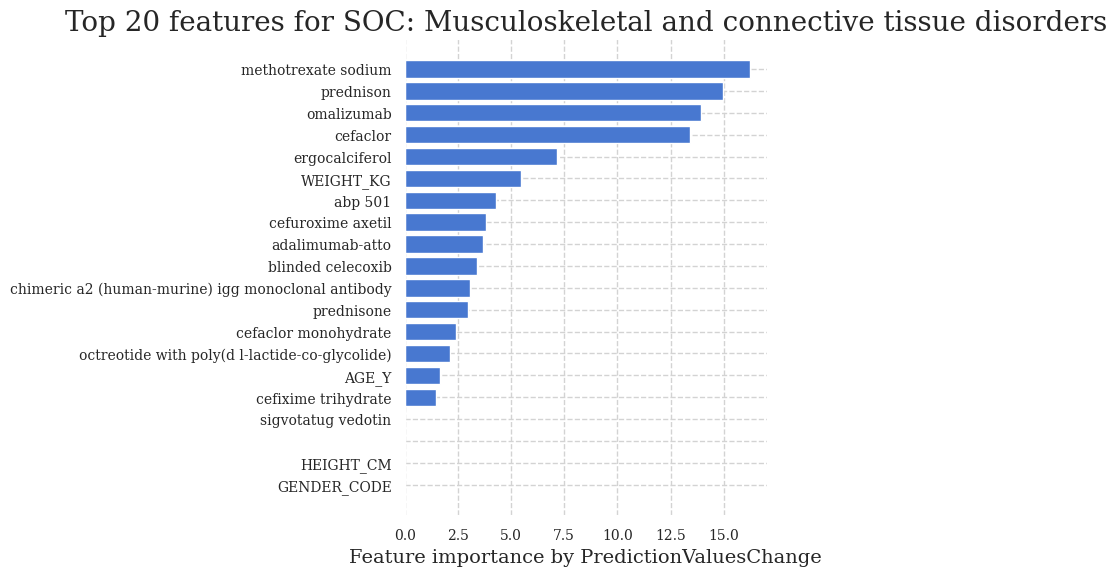

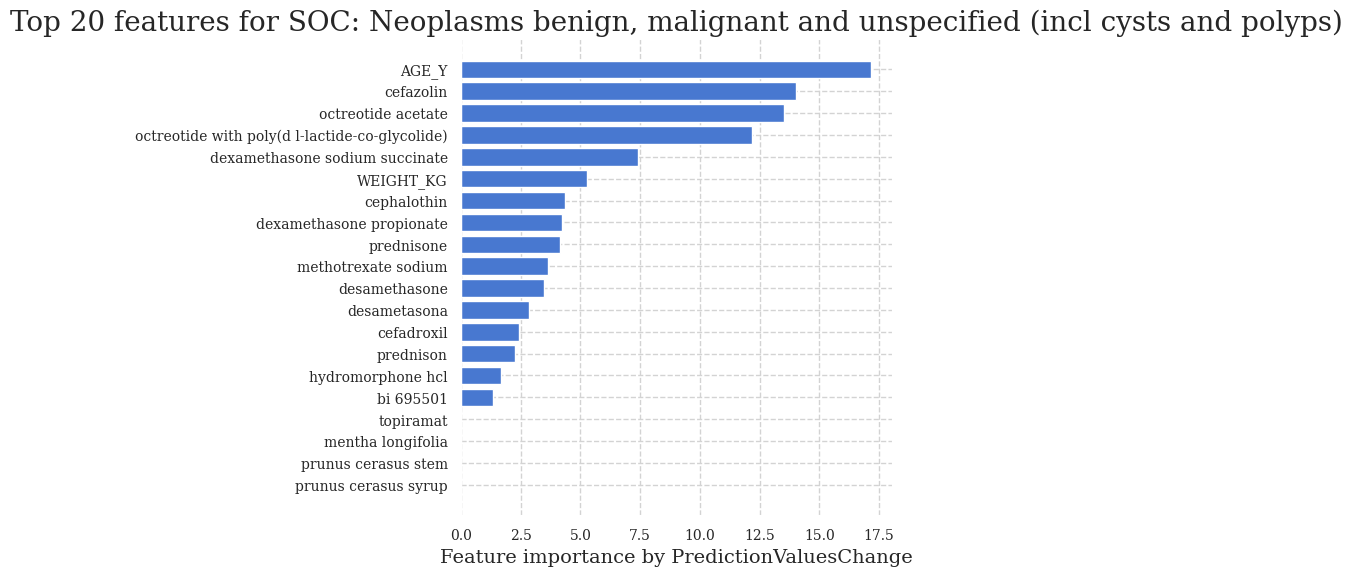

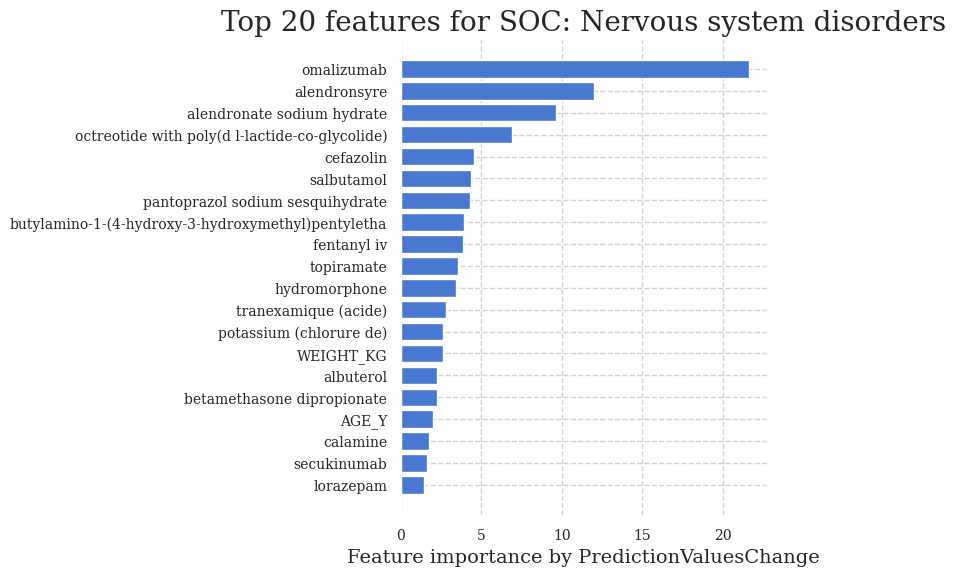

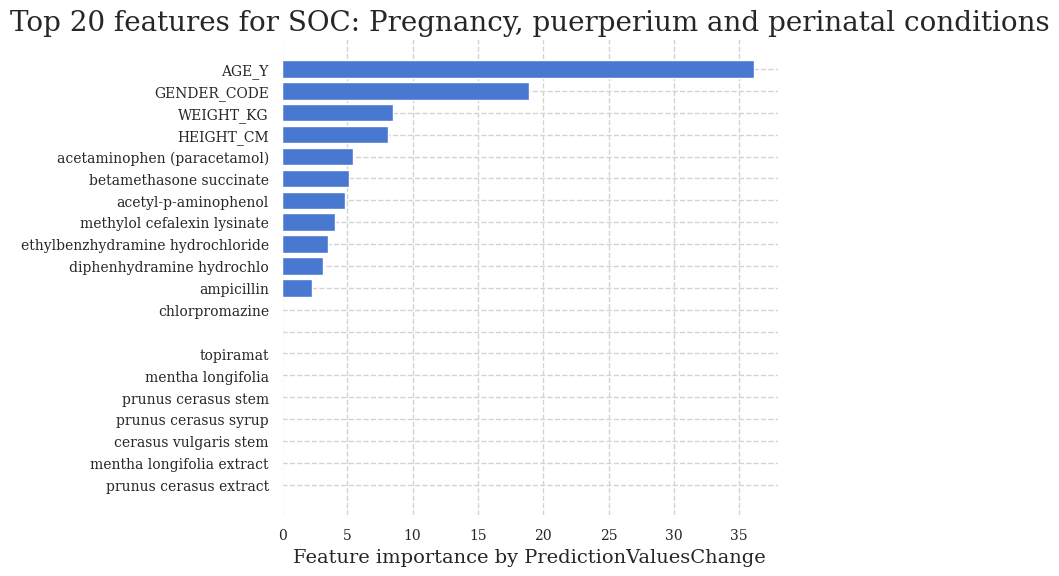

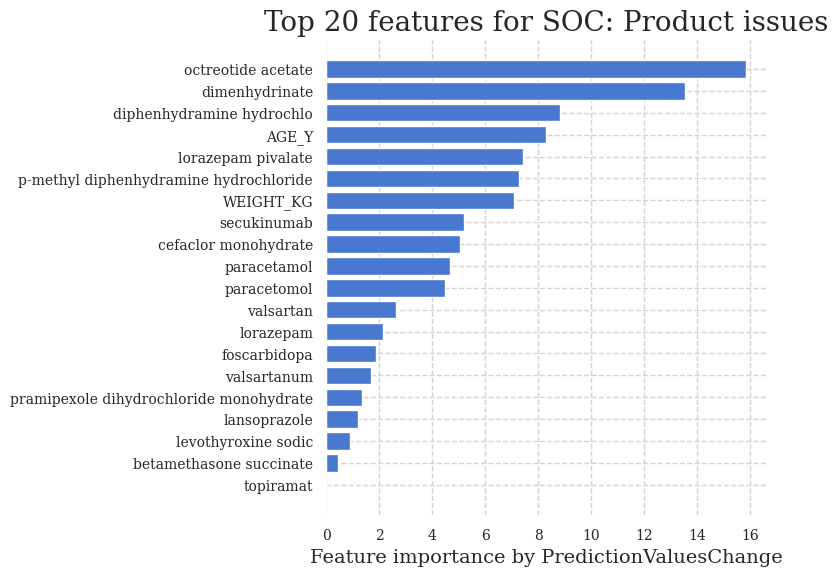

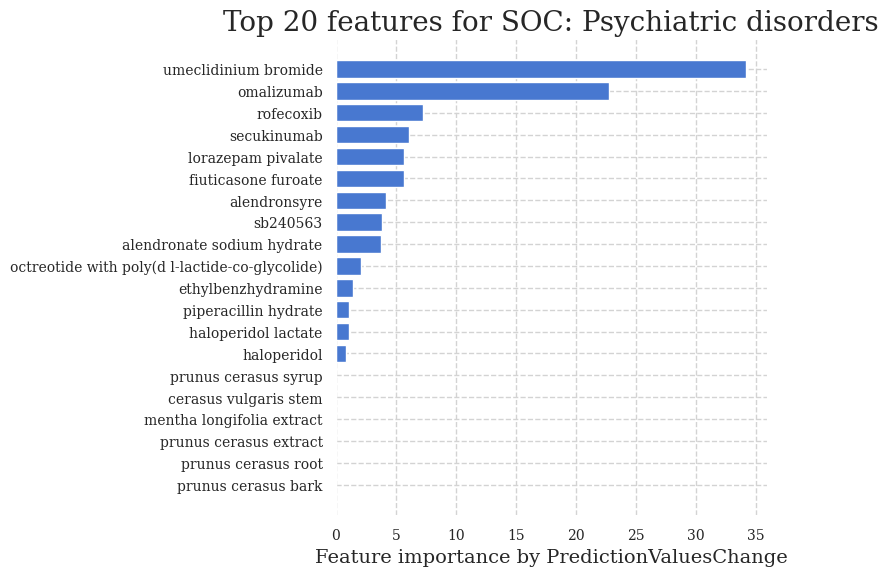

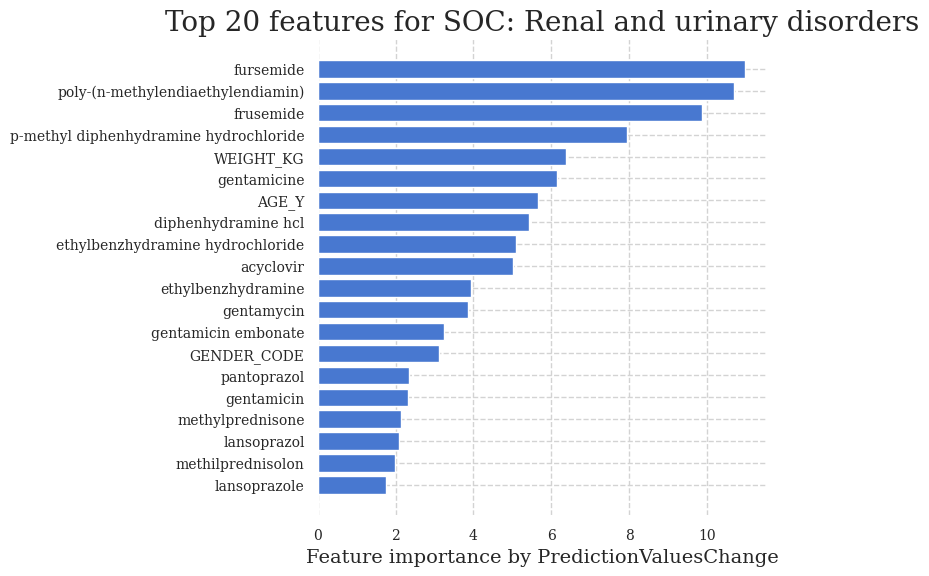

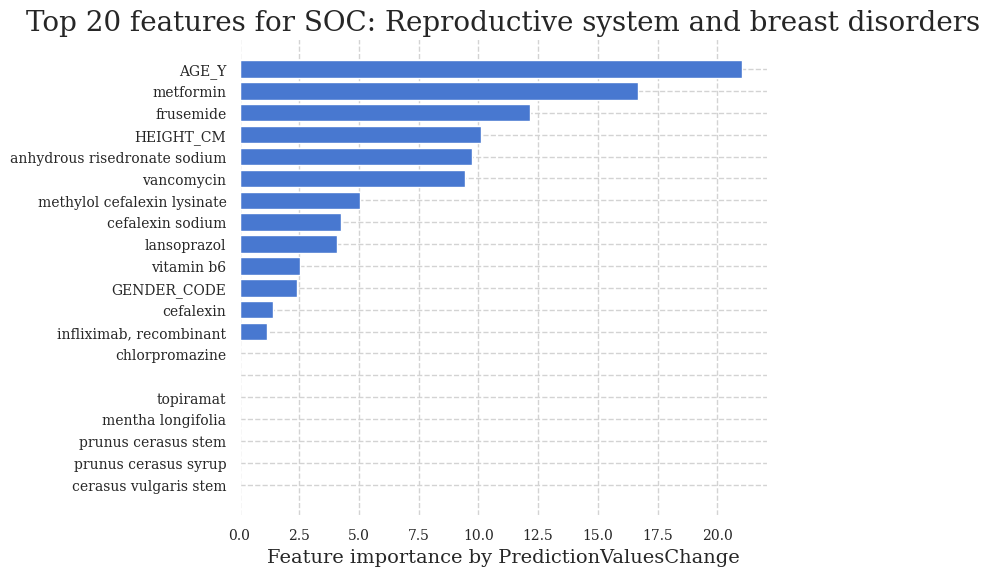

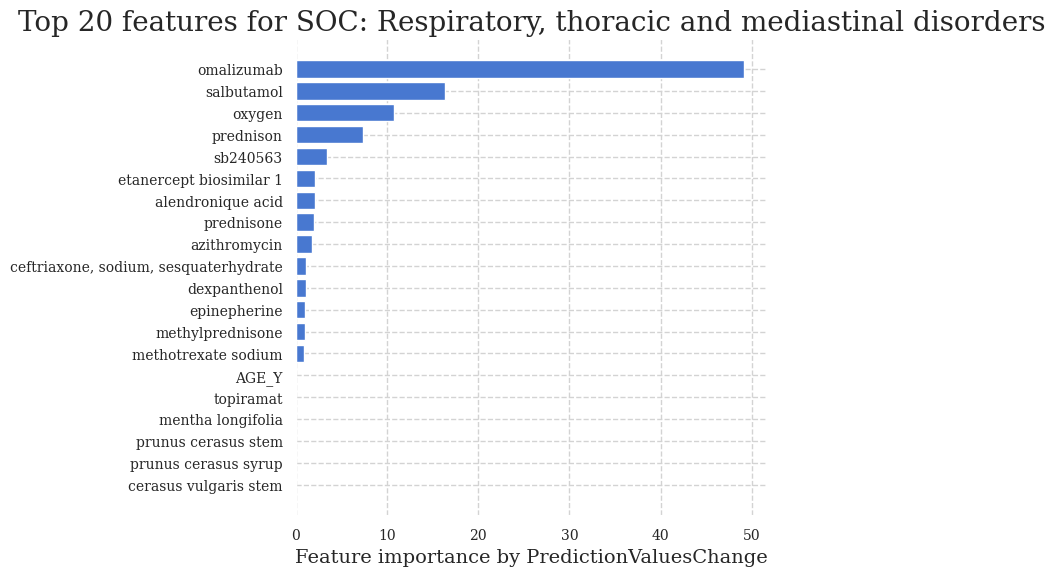

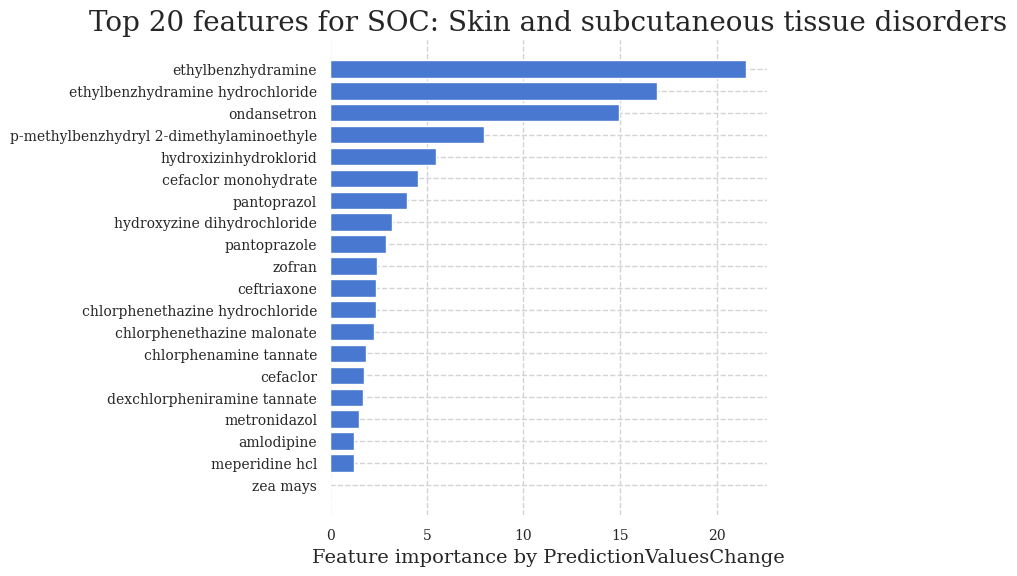

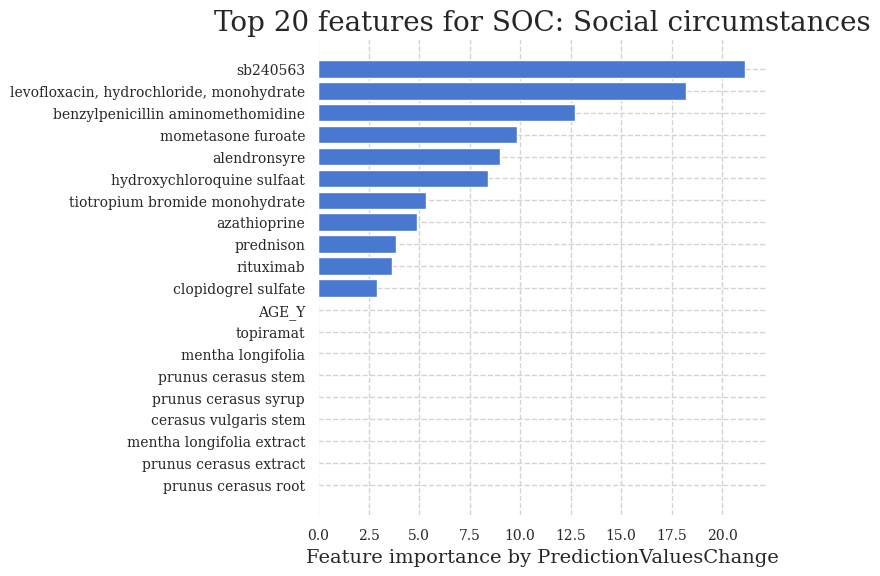

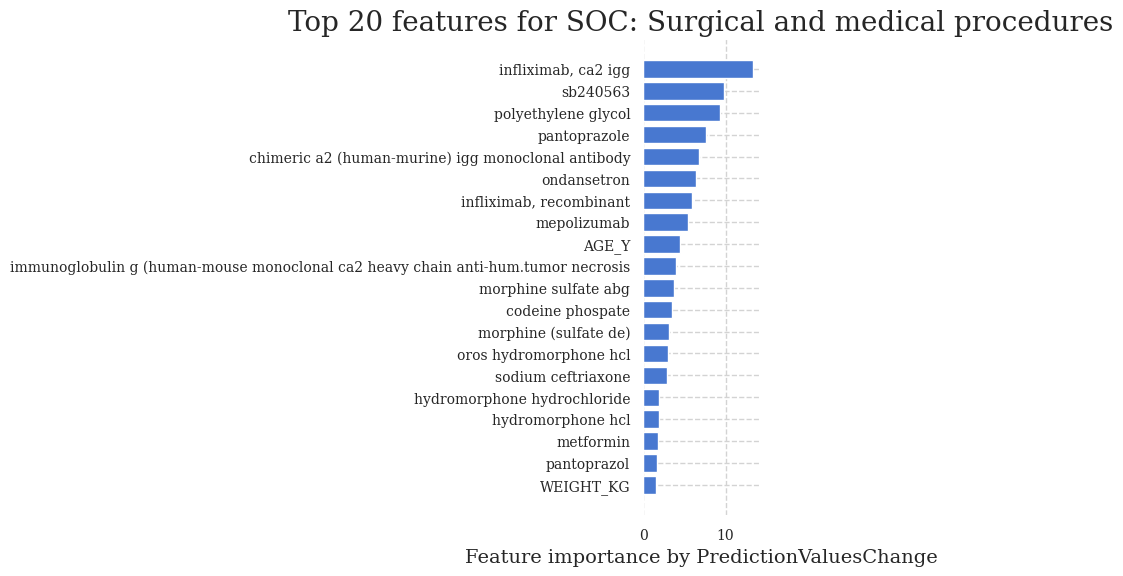

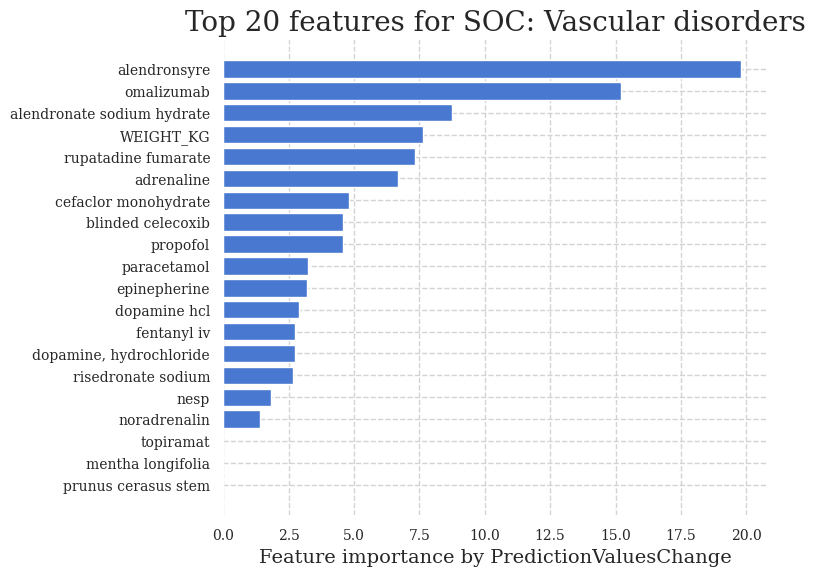

In [61]:
def plot_top_features_for_soc(
    soc_name,
    feature_importances_df,
    top_n=20,
    figsize=(8, 6),
    importance_type="FeatureImportance"
):
    """
    Plot the top_n most important features for a given SOC.
    """
    imp = feature_importances_df.loc[soc_name].sort_values(ascending=False).head(top_n)

    plt.figure(figsize=figsize)
    plt.barh(imp.index, imp.values)
    plt.title(f"Top {top_n} features for SOC: {soc_name}")
    plt.xlabel(f"Feature importance by {importance_type}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

for soc in soc_names:
    plot_top_features_for_soc(
        soc,
        feature_importances,
        importance_type="Feature Importance"
    )

for soc in soc_names:
    plot_top_features_for_soc(
        soc,
        feature_importances_pvc,
        importance_type="Prediction Values Change"
    )